## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'/src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

## Notebook Parameters

In [ ]:
import os 

### parameters 

notebook_name = 'exp9_new_experiment' # name of the notebook

## Generation of ground truth model 

model_name = 'v4_drug_model' # name of the model
o_random_seed = 5
p_overall_seed = 46 # different seed for parameter generation
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (1000, 5000)
param_range = (0.05, 20)
param_multiplier_range = (0.5, 1.5)


## Simulation parameters 

simulation_time = 1000 
simulation_step = 100

## Feature data generation 

feature_generation_method = 'lhs'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
    
## Data engineering parameters

# Suboptimal Model Generation 

'''
Options: 
- 'feedback_prune': removes feedback regulations from the model 
- 'random parameter': randomizes a x% of parameter values of the model
'''

''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

## General parameters
parallelise = True
save_figures = True 
experiment_id = notebook_name + '_' + str(o_random_seed) + '_' + '_' + str(feature_generation_seed)
experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)
    
print(experiment_folder)

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp9_new_experiment_5__50/


## Analysis

### Virtual Cell Creation

In [5]:
# create a drug enabled model 
from models.Utils import *
from models.DrugModelSpecification import DrugModelSpecification, Drug

model_drug_spec = DrugModelSpecification()
model_drug_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
drug_0 = Drug('D0', 500, 500)
rng = np.random.default_rng(o_random_seed)
# add random 'up' and 'down' regulations to the drug
regulation_dir = []
for i, s in enumerate(model_drug_spec.A_species):
    reg_type = str(rng.choice(['up', 'down']))
    regulation_dir.append(reg_type)
    drug_0.add_regulation(s, reg_type)
model_drug_spec.add_drug(drug_0)
print(model_drug_spec)
print(f'Feedback: {model_drug_spec.get_feedback_regulations()}')

A Species: ['A0', 'A1', 'A2', 'A3', 'A4']
B Species: ['B0', 'B1', 'B2', 'B3', 'B4']
C Species: ['C']
Regulations: [('B4', 'B3'), ('B4', 'B0'), ('A0', 'B0'), ('A1', 'B1'), ('A2', 'B2'), ('A3', 'B3'), ('A4', 'B4'), ('B0', 'C'), ('B1', 'C'), ('B2', 'C'), ('B0', 'C'), ('B1', 'C'), ('D0', 'A0'), ('D0', 'A1'), ('D0', 'A2'), ('D0', 'A3'), ('D0', 'A4')]
Regulation Types: ['up', 'down', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'down', 'down', 'down', 'down', 'up', 'down', 'up']
Drugs:
Drug(D0, 500, ['A0', 'A1', 'A2', 'A3', 'A4'], ['down', 'down', 'up', 'down', 'up'])

Feedback: [(('B4', 'B3'), 'up'), (('B4', 'B0'), 'down')]


In [6]:
p_random_seeds = []
feature_size = 1000 
rng = np.random.default_rng(p_overall_seed)
# generate `feature_size` random seeds for different parameter sets using numpy, ensure that the seeds are unique
p_random_seeds = rng.choice(range(1000000), feature_size, replace=False).tolist()

In [7]:
G0_d = model_drug_spec.generate_network('drug_model_524', 
                                        specie_value_range, 
                                        param_range, 
                                        param_multiplier_range,  
                                        verbose=0,
                                        random_seed=p_random_seeds[0])
base_parameters = G0_d.get_parameters()
base_initial_conditions = G0_d.get_state_variables()

print(G0_d.get_antimony_model())

model drug_model_524

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; J1_Vmax*A0/(J1_Km*(1+D0*J1_Kic0) + A0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; J3_Vmax*A1/(J3_Km*(1+D0*J3_Kic0) + A1)
J4: A2p -> A2; J4_Vmax*A2p/(J4_Km + A2p)
J5: A2 -> A2p; (J5_Vmax+D0*J5_Kw0)*A2/(J5_Km + A2)
J6: A3p -> A3; J6_Vmax*A3p/(J6_Km + A3p)
J7: A3 -> A3p; J7_Vmax*A3/(J7_Km*(1+D0*J7_Kic0) + A3)
J8: A4p -> A4; J8_Vmax*A4p/(J8_Km + A4p)
J9: A4 -> A4p; (J9_Vmax+D0*J9_Kw0)*A4/(J9_Km + A4)
J10: B0p -> B0; J10_Vmax*B0p/(J10_Km + B0p)
J11: B0 -> B0p; (J11_Vmax+A0p*J11_Kw0)*B0/(J11_Km*(1+B4p*J11_Kic0) + B0)
J12: B1p -> B1; J12_Vmax*B1p/(J12_Km + B1p)
J13: B1 -> B1p; (J13_Vmax+A1p*J13_Kw0)*B1/(J13_Km + B1)
J14: B2p -> B2; J14_Vmax*B2p/(J14_Km + B2p)
J15: B2 -> B2p; (J15_Vmax+A2p*J15_Kw0)*B2/(J15_Km + B2)
J16: B3p -> B3; J16_Vmax*B3p/(J16_Km + B3p)
J17: B3 -> B3p; (J17_Vmax+B4p*J17_Kw0+A3p*J17_Kw1)*B3/(J17_Km + B3)
J18: B4p -> B4; J18_Vmax*B4p/(J18_Km + B4p)
J19: B4 -> B4p; (J19_Vmax+A4p*J19_Kw

In [8]:
parameter_sets = []
for p in p_random_seeds: 
    model_build = model_drug_spec.generate_network(f'param_seed_{p}', 
                                            specie_value_range, param_range, param_multiplier_range, random_seed=p, verbose=0)
    parameter_sets.append(model_build.get_parameters())

In [9]:
# test simulation 

from models.Solver.RoadrunnerSolver import RoadrunnerSolver

solver = RoadrunnerSolver()
solver.compile(G0_d.get_sbml_model())

result = solver.simulate(0, 1000, 100)
result

,time,A0p,A0,A1p,A1,A2p,A2,A3p,A3,A4p,...,B4p,B1p,B1,B2p,B2,B3p,B3,B4,C,Cp
0,0.00000,0.000000,4658.000000,0.000000,1693.000000,0.000000,4115.000000,0.000000,3260.000000,0.000000,...,0.000000,0.000000,1701.000000,0.000000,1389.000000,0.000000,4670.000000,4338.000000,100.000000,0.000000
1,10.10101,16.728794,4641.271206,14.774982,1678.225018,16.564195,4098.435805,16.205188,3243.794812,15.704010,...,108.185843,90.740278,1610.259722,95.794539,1293.205461,580.106757,4089.893243,4229.814157,97.275548,2.724452
2,20.20202,25.894613,4632.105387,22.810731,1670.189269,25.634743,4089.365257,25.067955,3234.932045,24.276789,...,303.538737,247.987442,1453.012558,263.148024,1125.851976,3025.815421,1644.184579,4034.461263,96.309548,3.690452
3,30.30303,31.065564,4626.934436,27.296692,1665.703308,30.747753,4084.252247,30.054703,3229.945297,29.087592,...,535.178338,424.538033,1276.461967,449.030908,939.969092,4658.351653,11.648347,3802.821662,95.890035,4.109965
4,40.40404,34.028072,4623.971928,29.835564,1663.164436,33.674257,4081.325743,32.902850,3227.097150,31.826787,...,783.269739,601.584985,1099.415015,629.891665,759.108335,4662.154990,7.845010,3554.730261,95.706293,4.293707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,959.59596,0.673457,4657.326543,0.247327,1692.752673,4102.462614,12.537386,0.473637,3259.526363,2485.129635,...,4335.525110,38.348176,1662.651824,1387.720895,1.279105,4668.576974,1.423026,2.474890,60.705729,39.294271
96,969.69697,0.673457,4657.326543,0.247327,1692.752673,4102.462614,12.537386,0.473637,3259.526363,2485.129635,...,4335.525110,38.348182,1662.651818,1387.720895,1.279105,4668.576974,1.423026,2.474890,60.705743,39.294257
97,979.79798,0.673457,4657.326543,0.247327,1692.752673,4102.462614,12.537386,0.473637,3259.526363,2485.129635,...,4335.525110,38.348189,1662.651811,1387.720895,1.279105,4668.576974,1.423026,2.474890,60.705753,39.294247
98,989.89899,0.673457,4657.326543,0.247327,1692.752673,4102.462614,12.537386,0.473637,3259.526363,2485.129635,...,4335.525110,38.348196,1662.651804,1387.720895,1.279105,4668.576974,1.423026,2.474890,60.705757,39.294243


### Generate synthetic 'omics-like' data

In [10]:
from models.SyntheticGen import generate_feature_data, generate_target_data, generate_feature_data_v2, generate_target_data_diff_build

feature_data = generate_feature_data_v2(model_drug_spec, base_initial_conditions, feature_generation_method, feature_generation_extra_params, 1000, feature_generation_seed)
target_data, _ = generate_target_data_diff_build(model_drug_spec, solver, 
                                                 feature_data, parameter_sets, 
                                                 {'start': 0, 'end': 1000, 'points': 100}, 
                                                 n_cores=1, verbose=True)


Simulating perturbations: 100%|██████████| 1000/1000 [00:02<00:00, 338.75it/s]


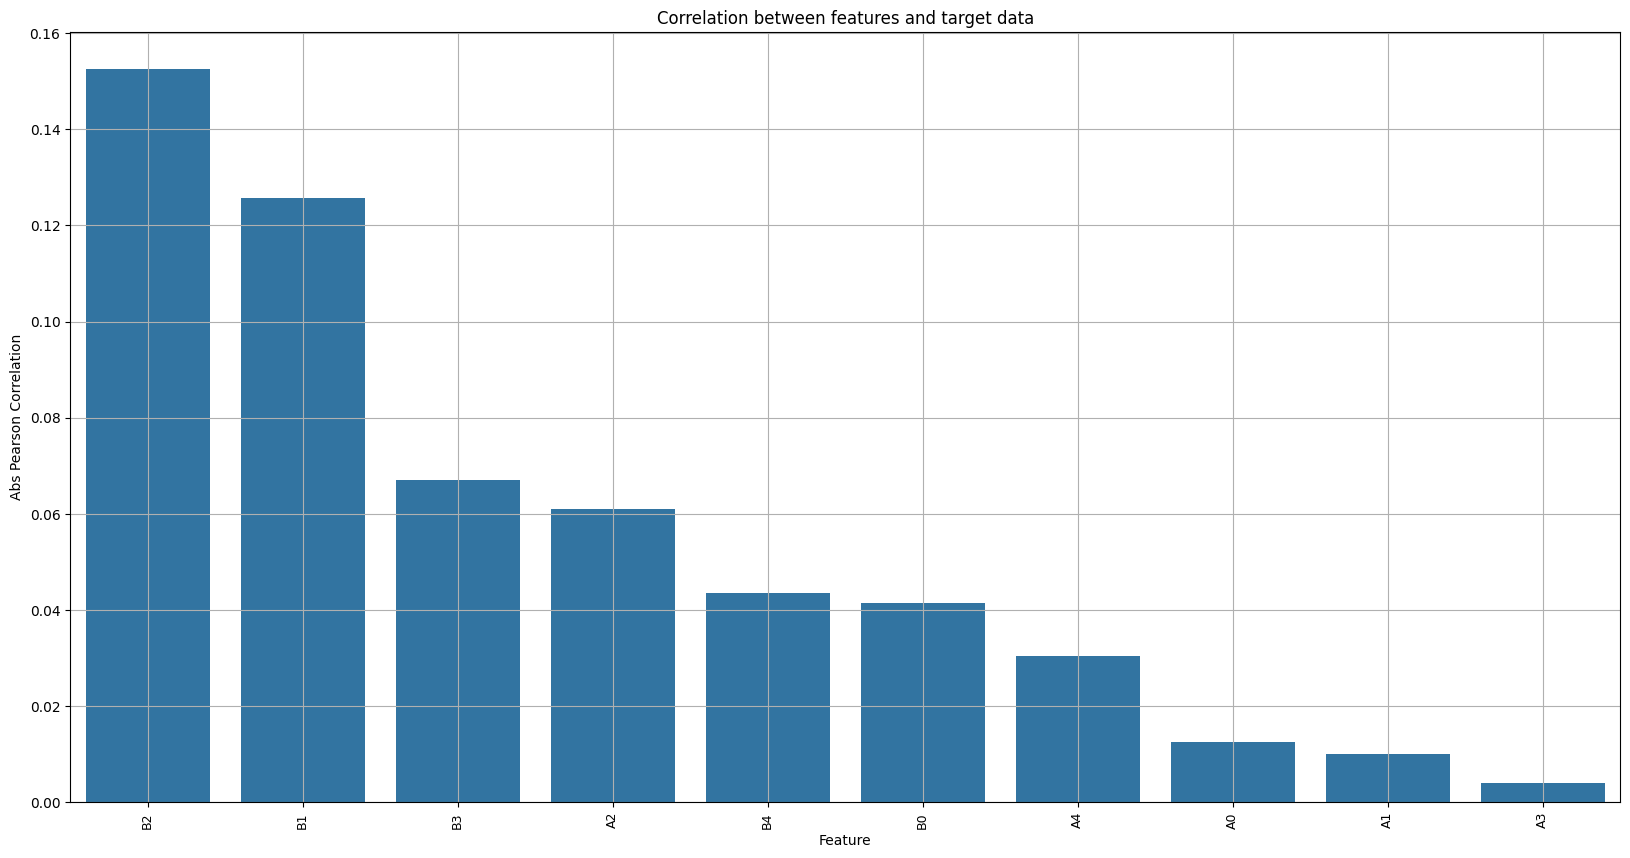

In [11]:
# plot the association between the features and the target data in a bar chart based on the correlation values 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# create a dataframe with the feature data and target data
feature_data_df = pd.DataFrame(feature_data)
target_data_df = pd.DataFrame(target_data)
# add the target data to the feature data
feature_data_df['target'] = target_data_df['Cp']

# calculate the correlation between the features and the target data
correlation = feature_data_df.corr()['target'].sort_values(ascending=False)
# create a dataframe with the correlation values
correlation_df = pd.DataFrame(correlation)
correlation_df = correlation_df.reset_index()
correlation_df.columns = ['feature', 'correlation']
# do not include the target data in the correlation dataframe
correlation_df = correlation_df[correlation_df['feature'] != 'target']
abs_correlation_df = correlation_df.copy()
# take the absolute value of the correlation
abs_correlation_df['correlation'] = abs(abs_correlation_df['correlation'])
# sort the dataframe by the absolute value of the correlation
abs_correlation_df = abs_correlation_df.sort_values(by='correlation', ascending=False)
abs_correlation_df_50 = abs_correlation_df.head(50)
# plot the correlation values
plt.figure(figsize=(20, 10))
sns.barplot(x='feature', y='correlation', data=abs_correlation_df_50)
plt.title('Correlation between features and target data')
plt.xlabel('Feature')
plt.ylabel('Abs Pearson Correlation')
plt.xticks(rotation=90, fontsize=9)
plt.grid()
plt.show()

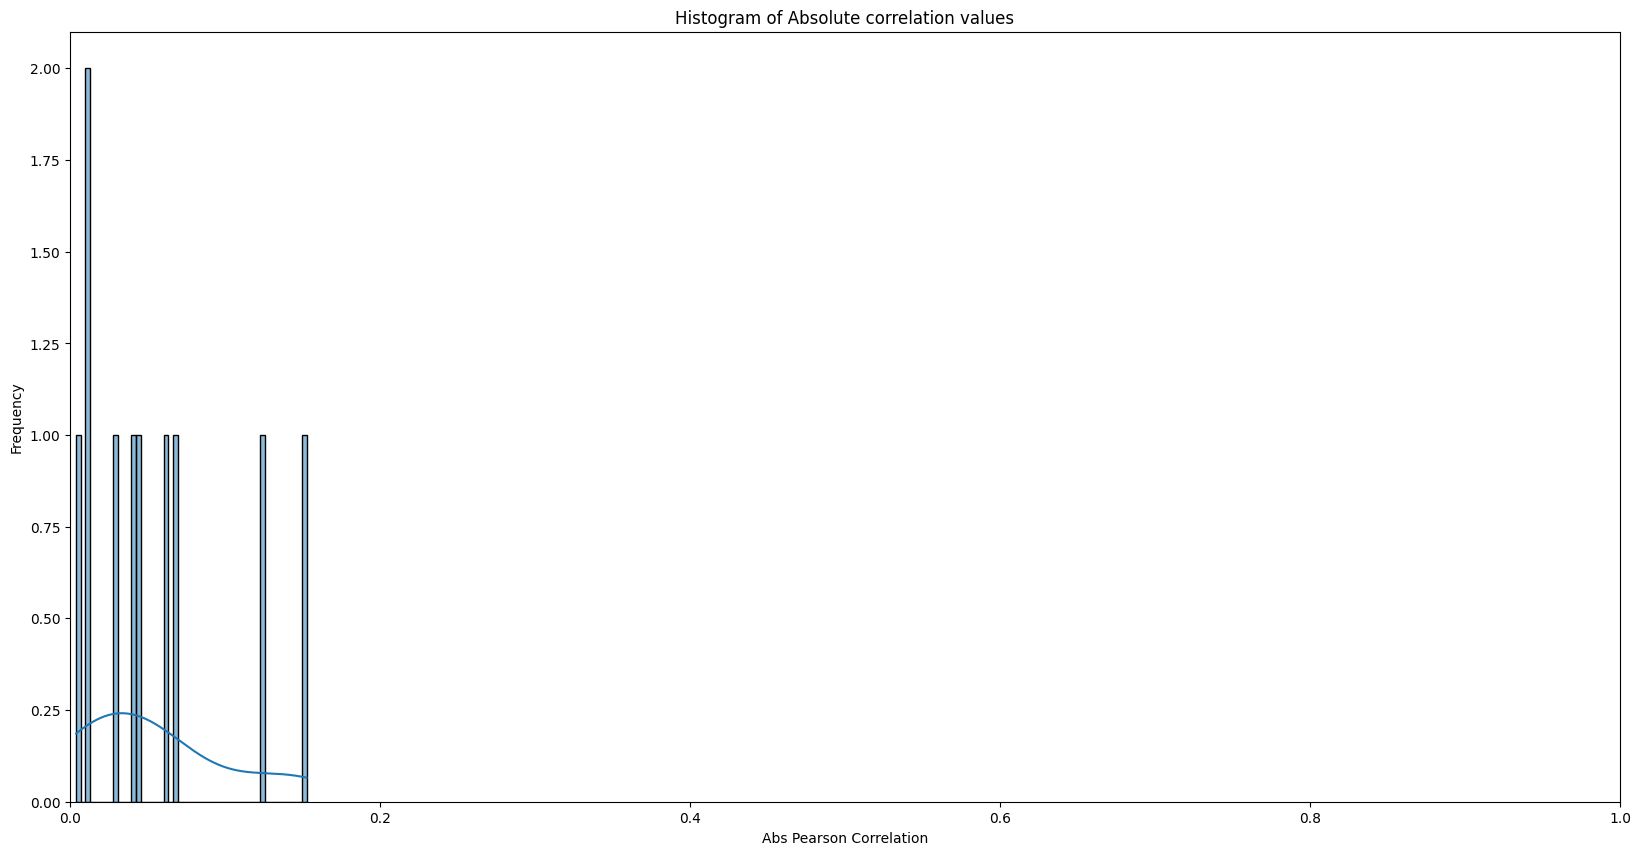

In [12]:
# make a histogram of the correlation values
plt.figure(figsize=(20, 10))
sns.histplot(abs_correlation_df['correlation'], bins=50, kde=True)
plt.title('Histogram of Absolute correlation values')
plt.xlabel('Abs Pearson Correlation')
plt.ylabel('Frequency')
plt.xlim(0,1)
plt.show()

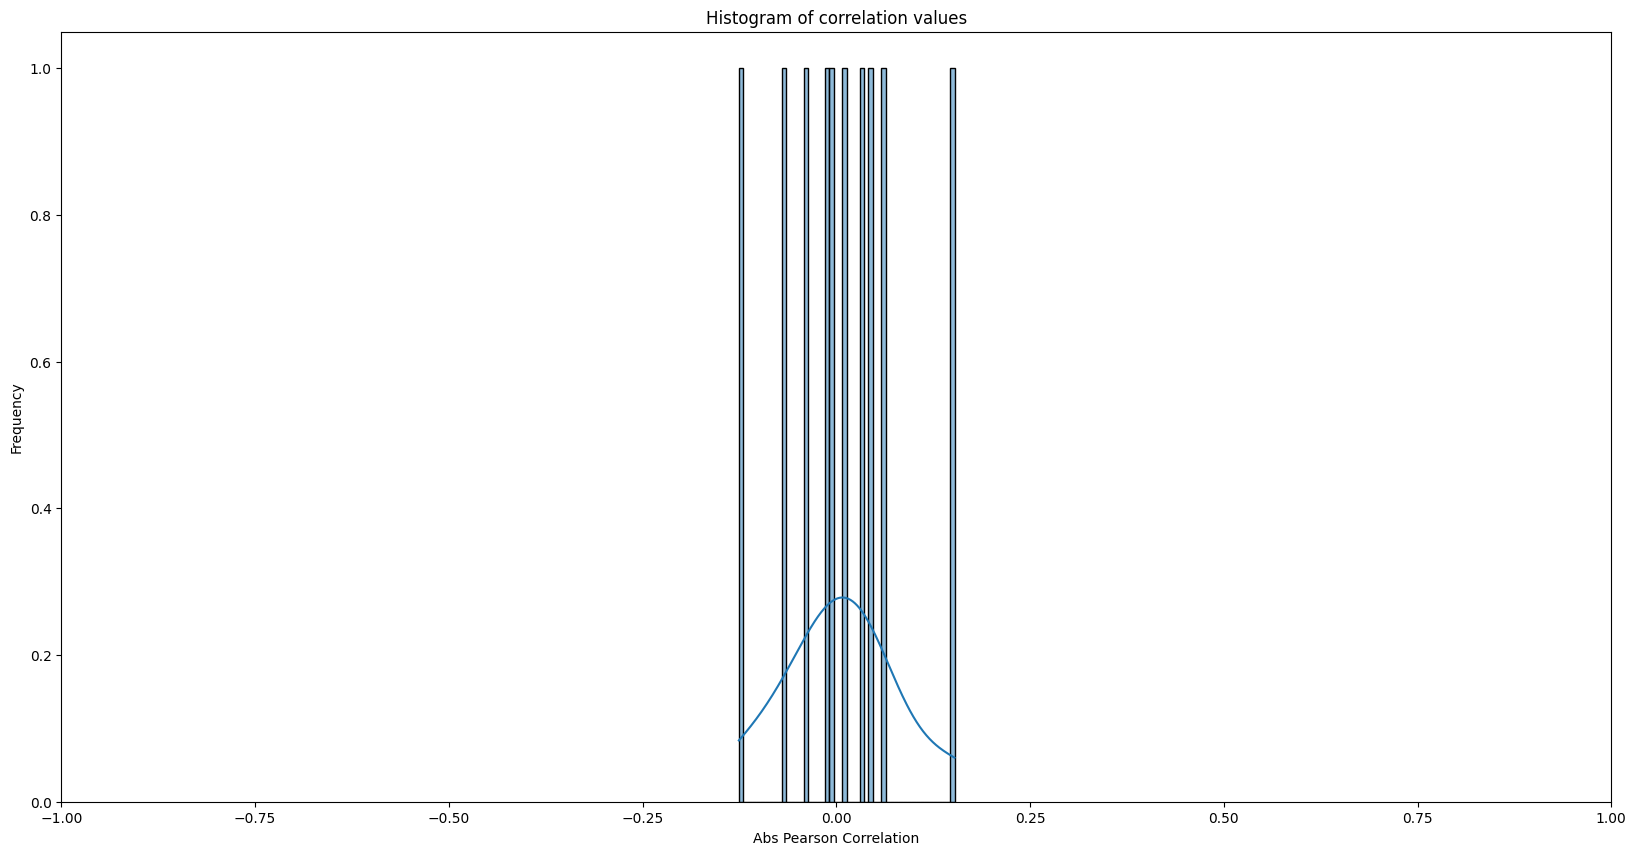

In [13]:
# make a histogram of the correlation values
plt.figure(figsize=(20, 10))
sns.histplot(correlation_df['correlation'], bins=50, kde=True)
plt.title('Histogram of correlation values')
plt.xlabel('Abs Pearson Correlation')
plt.ylabel('Frequency')
plt.xlim(-1,1)
plt.show()

In [14]:
# extract the mean and standard deviation of the correlation values
mean = np.mean(correlation_df['correlation'])
std = np.std(correlation_df['correlation'])
max_val = np.max(correlation_df['correlation'])
min_val = np.min(correlation_df['correlation'])
outliers = correlation_df[(correlation_df['correlation'] > mean + 3*std) | (correlation_df['correlation'] < mean - 3*std)]

print(f'Mean: {mean:.4f}')
print(f'Standard Deviation: {std:.4f}')
print(f'Max: {max_val:.4f}')
print(f'Min: {min_val:.4f}')
print(f'Outliers as a ratio of all features: {outliers.shape[0] / correlation_df.shape[0]:.4f}')

Mean: 0.0052
Standard Deviation: 0.0720
Max: 0.1526
Min: -0.1257
Outliers as a ratio of all features: 0.0000


10 features selected based on correlation with target data


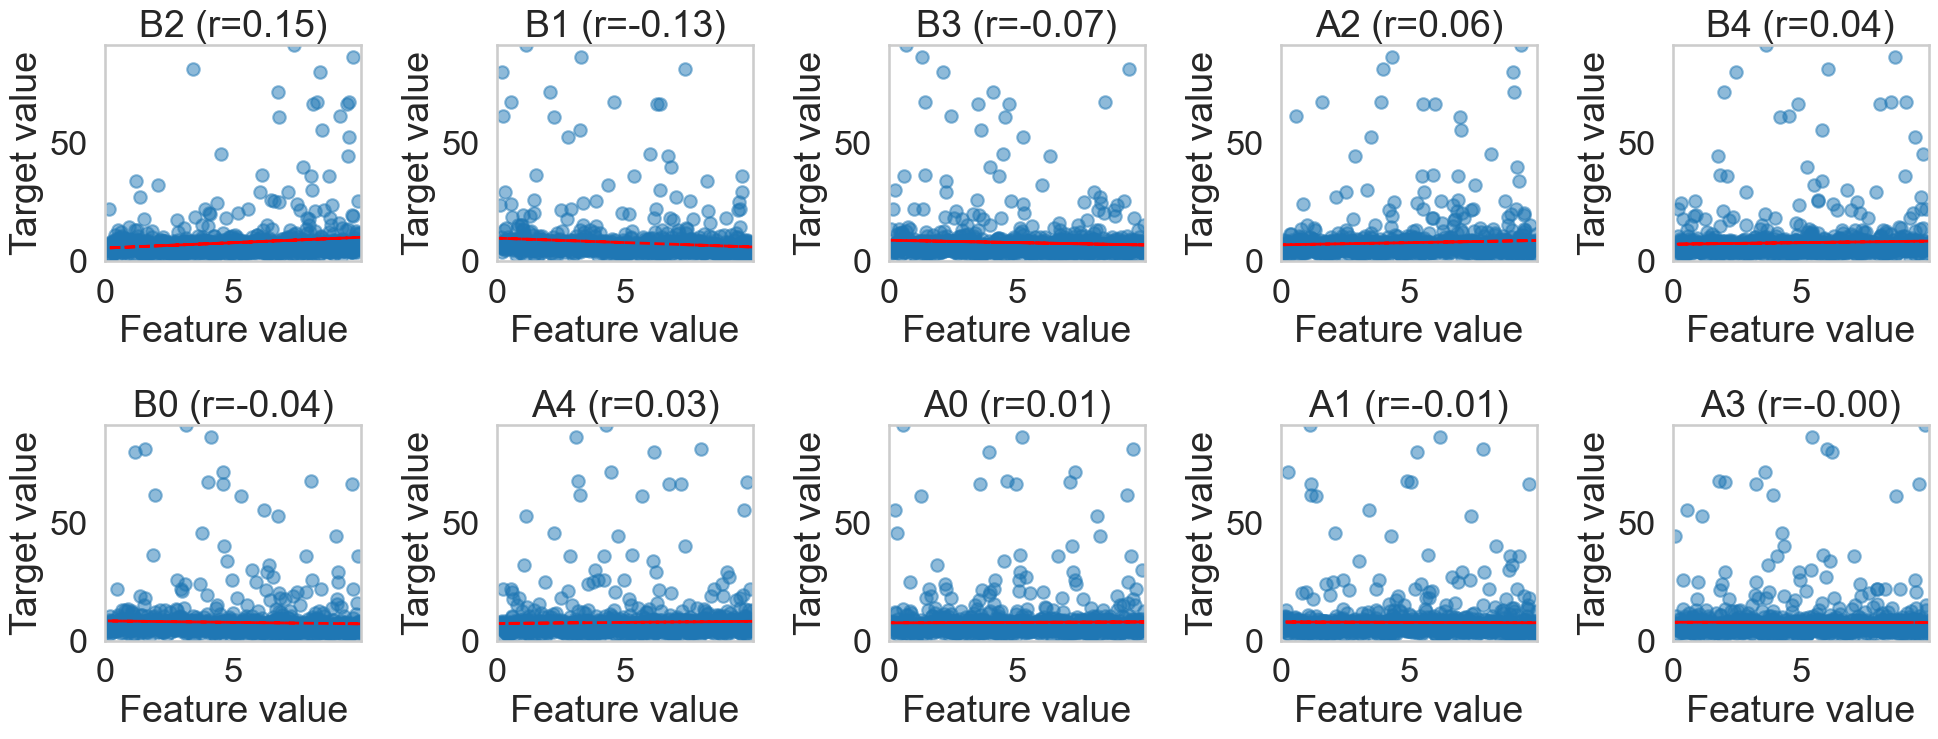

In [15]:
# plot association between the features and the target data 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for each feature, plot the association with the target data, which is only a series 
# plot all features in separate subplots
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.5) 

n_features = len(feature_data.columns)
# plot only the top 10 features based on the absolute correlation values
top_features = abs_correlation_df['feature'].values[:10]
# create a new dataframe with only the top features
top_feature_data = feature_data[top_features]
print(f'{len(top_feature_data.columns)} features selected based on correlation with target data')
# make a subplot based on the size of feature_data, have five columns and as many rows as needed
top_n_features = len(top_feature_data.columns)
n_rows = int(top_n_features / 5) 
n_cols = 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axs = axs.flatten()


# plot each feature in a separate subplot
for i, feature in enumerate(top_feature_data.columns):
    x = top_feature_data[feature].values.ravel()  # ensure 1D
    y = target_data.values.ravel()            # ensure 1D
    axs[i].scatter(x, y, alpha=0.5)
    # add a dash linear regression line with a pearson correlation coefficient
    # compute the pearson correlation coefficient
    corr, _ = pearsonr(x, y)
    # add a linear regression line
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))
    axs[i].plot(x, y_pred, color='red', linestyle='--', linewidth=2)
    axs[i].set_title(f'{feature} (r={corr:.2f})')

    axs[i].set_xlabel('Feature value')
    axs[i].set_ylabel('Target value')
    axs[i].grid()
    # set the x and y limits to be the same for all subplots
    max_feature = top_feature_data[feature].values.max()   
    max_target = target_data.values.max()  
    axs[i].set_xlim([0,max_feature])
    axs[i].set_ylim([0,max_target])
    # compute the correlation between the feature and target data
plt.tight_layout()
plt.show()

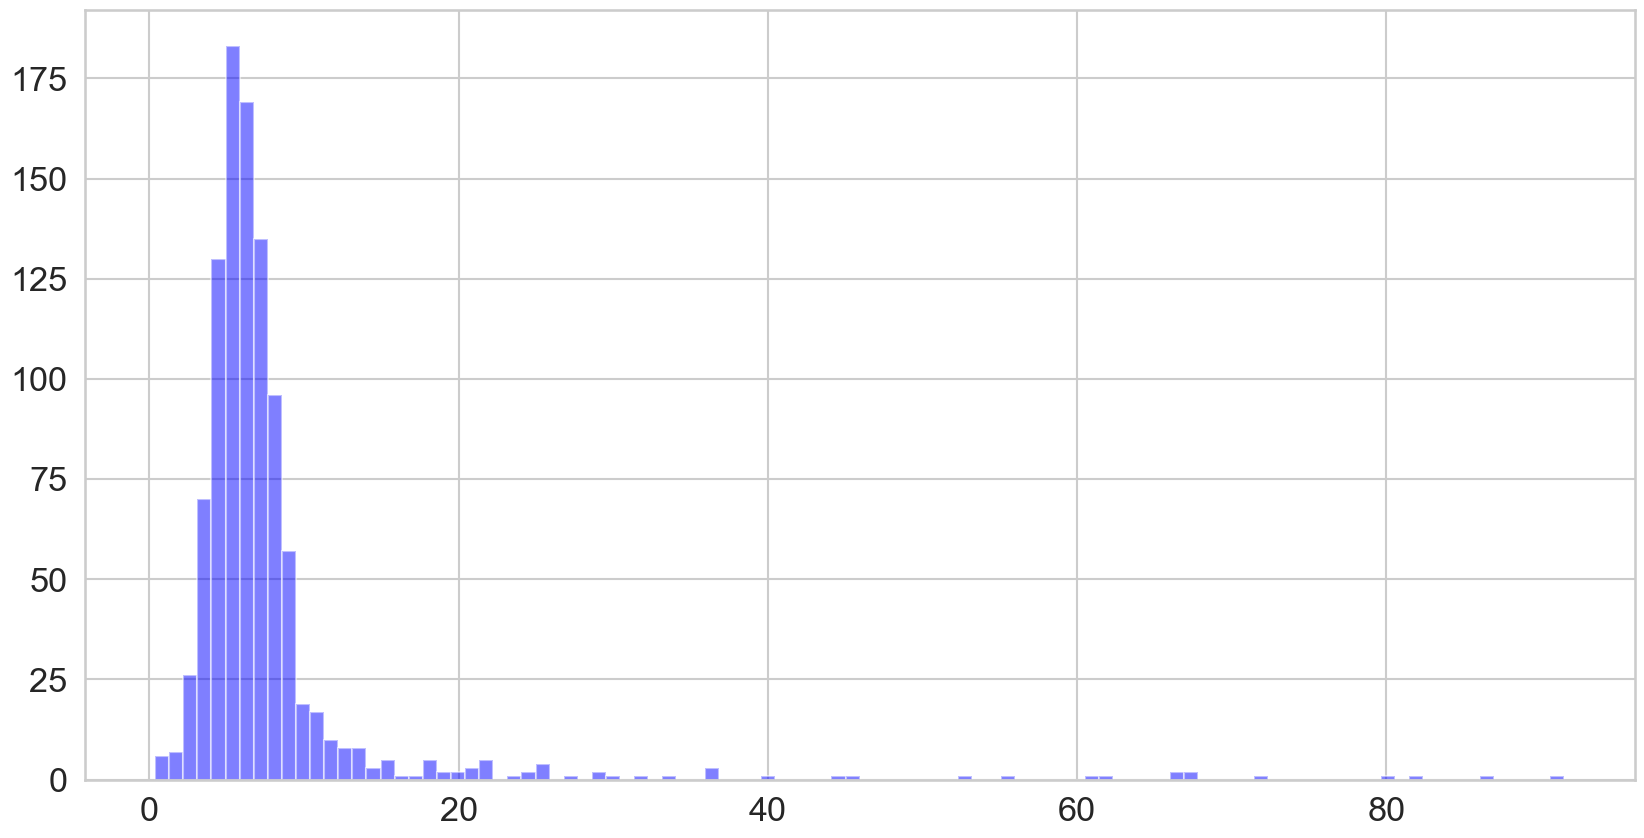

In [16]:
# plot the target data only with the x axis being 0 to 100 
plt.figure(figsize=(20, 10))
plt.hist(target_data, bins=100, alpha=0.5, color='blue')
plt.show()

### Simulation / Extract dynamic feature data

In [17]:
from models.SyntheticGen import generate_model_timecourse_data, generate_model_timecourse_data_diff_build

# generate the timecourse data for the new model
time_course_data = generate_model_timecourse_data_diff_build(model_drug_spec, 
                                                  solver, 
                                                  feature_data, 
                                                  parameter_sets,
                                                  {'start': 0, 'end': 1000, 'points': 100}, 
                                                  capture_species='all', n_cores=1, verbose=True)


Simulating perturbations: 100%|██████████| 1000/1000 [00:03<00:00, 307.57it/s]


In [18]:
from models.Utils import last_time_point_method, dynamic_features_method

all_species = model_drug_spec.A_species + model_drug_spec.B_species + model_drug_spec.C_species
all_phos_species = [s+'p' for s in all_species]
# apply the data engineering method to the feature data
last_time_data = last_time_point_method(time_course_data, all_phos_species)

In [19]:
dynamic_data = dynamic_features_method(time_course_data, all_phos_species, n_cores=8)

In [20]:
combined_lp_data = pd.concat([feature_data, last_time_data], axis=1)
combined_dyn_data = pd.concat([feature_data, dynamic_data], axis=1)


In [21]:
feature_data_list = [feature_data, last_time_data, dynamic_data, combined_lp_data, combined_dyn_data]
feature_data_names = ['feature_data', 'last_time_data', 'dynamic_data', 'combined_lp_data', 'combined_dyn_data']

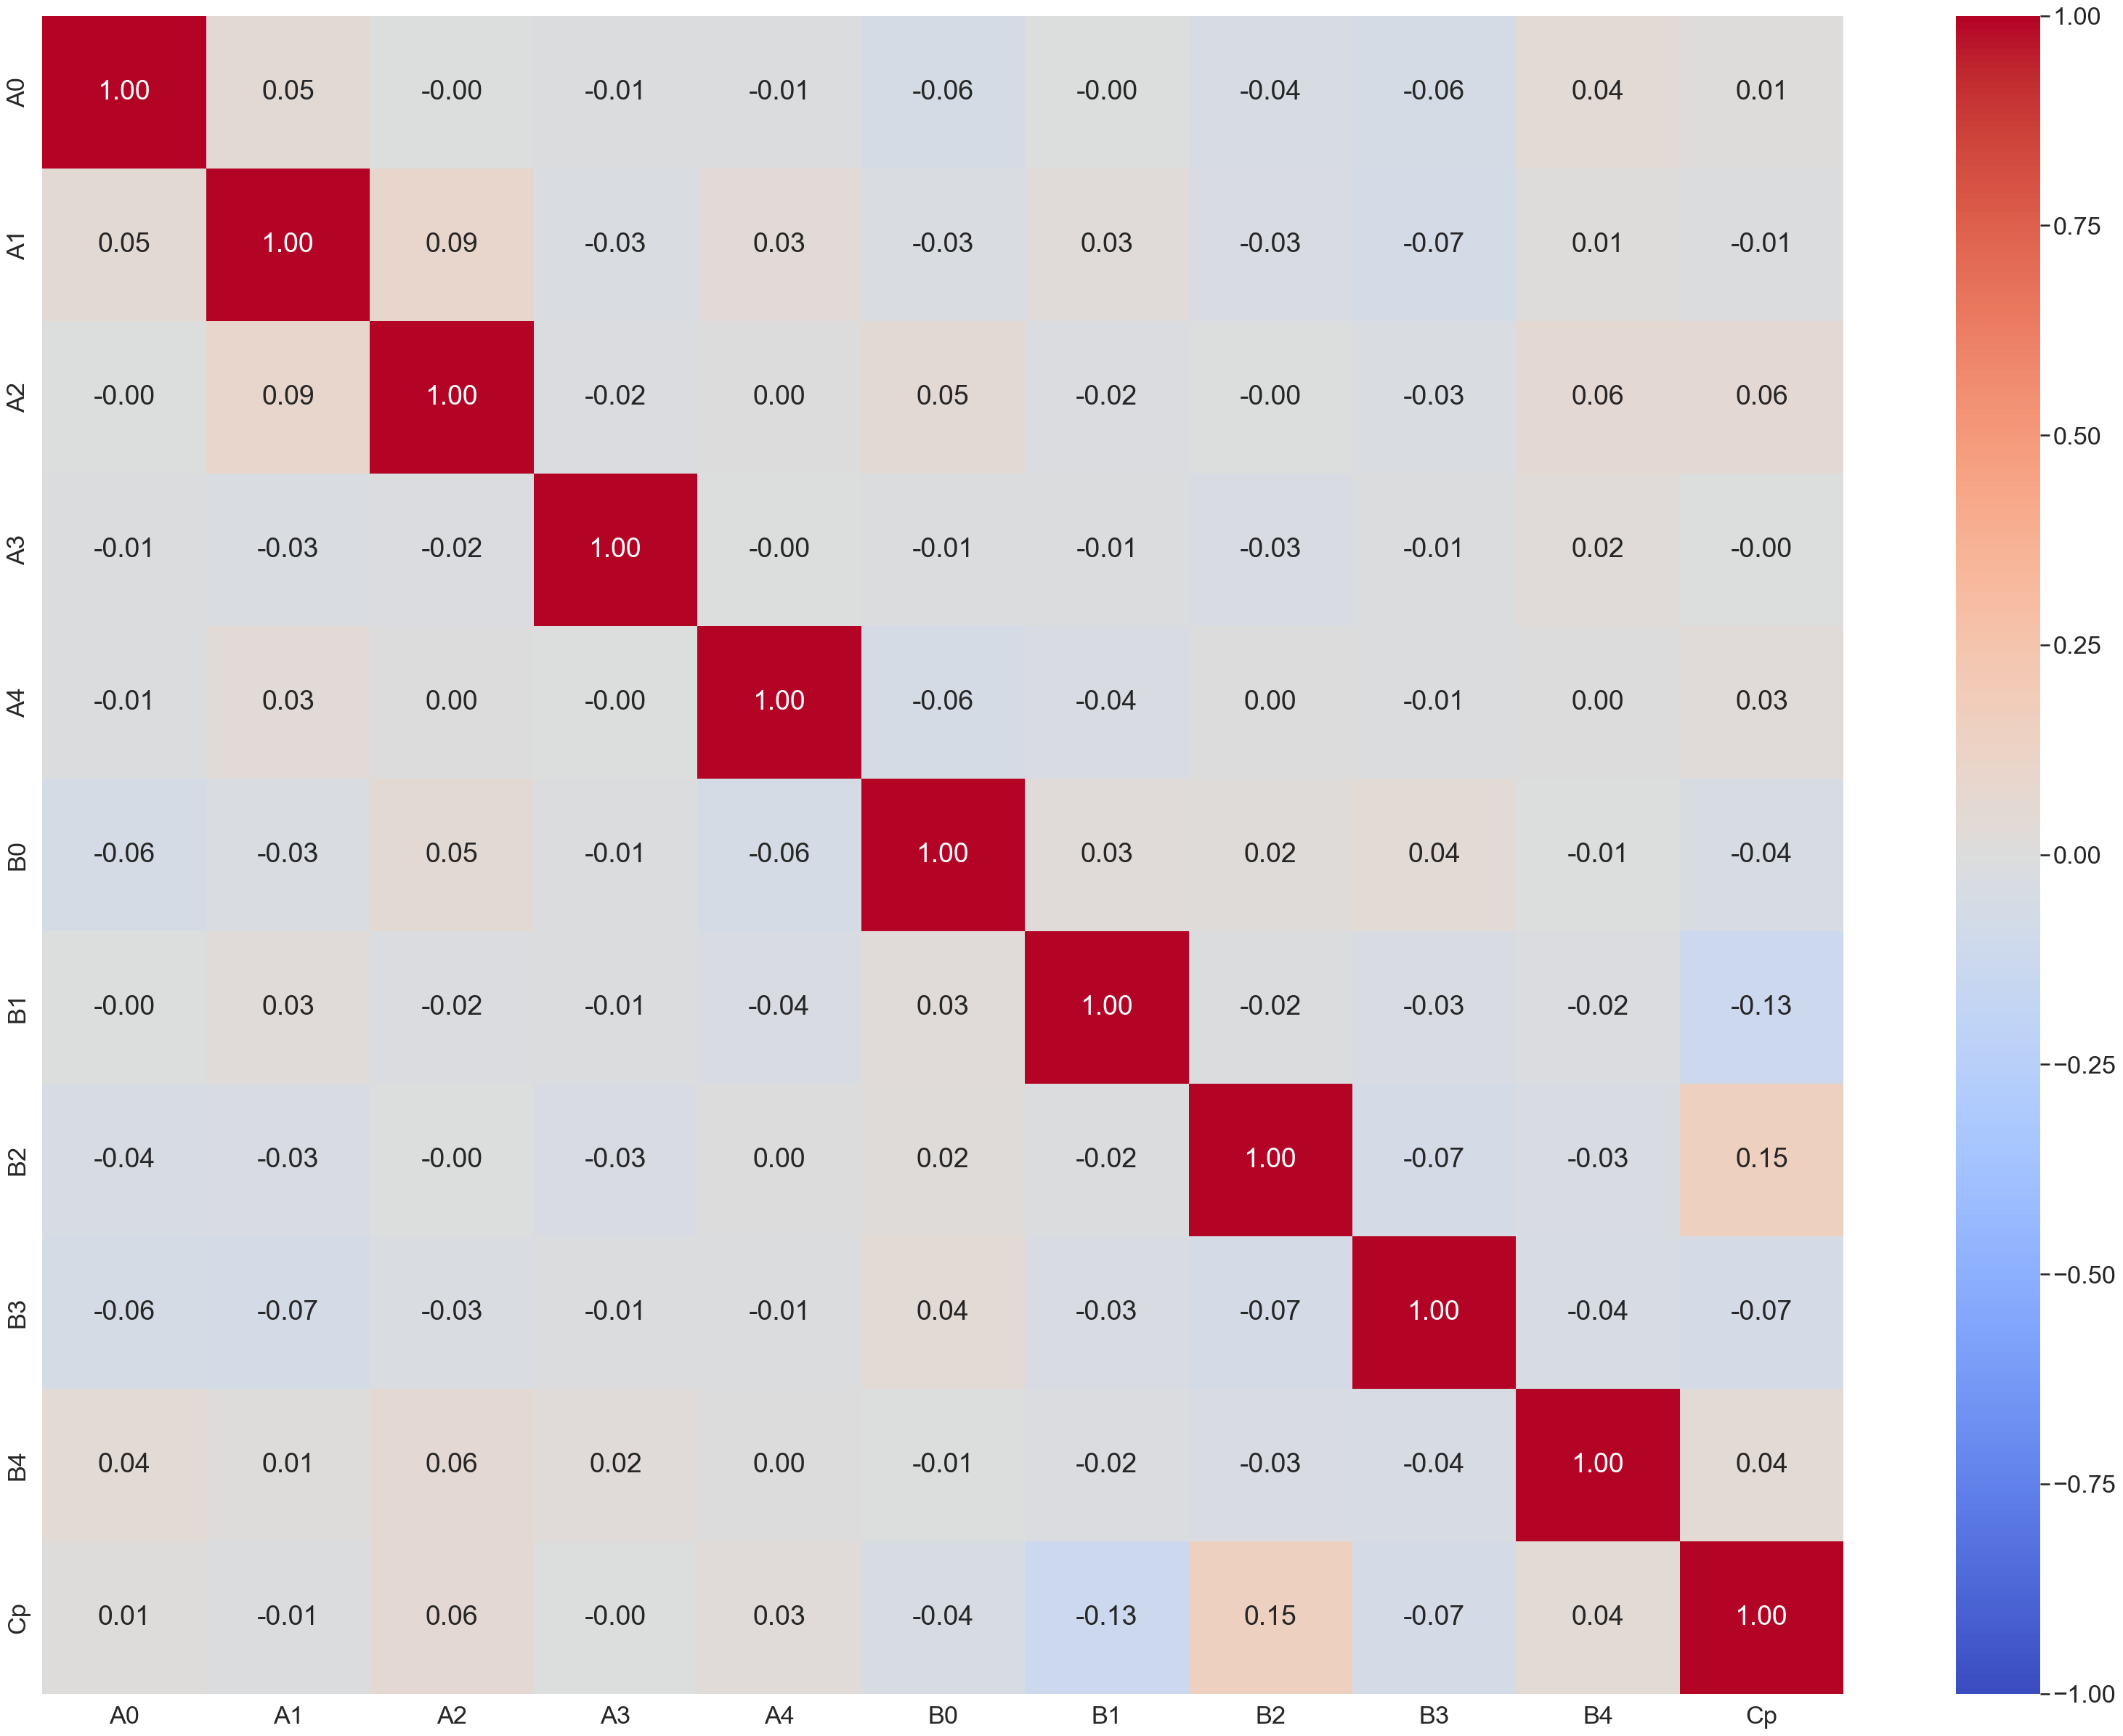

In [22]:
import seaborn as sns
feature_target_df = feature_data.copy()
feature_target_df['Cp'] = target_data['Cp']
plt.figure(figsize=(40, 30))
sns.heatmap(feature_target_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.show()

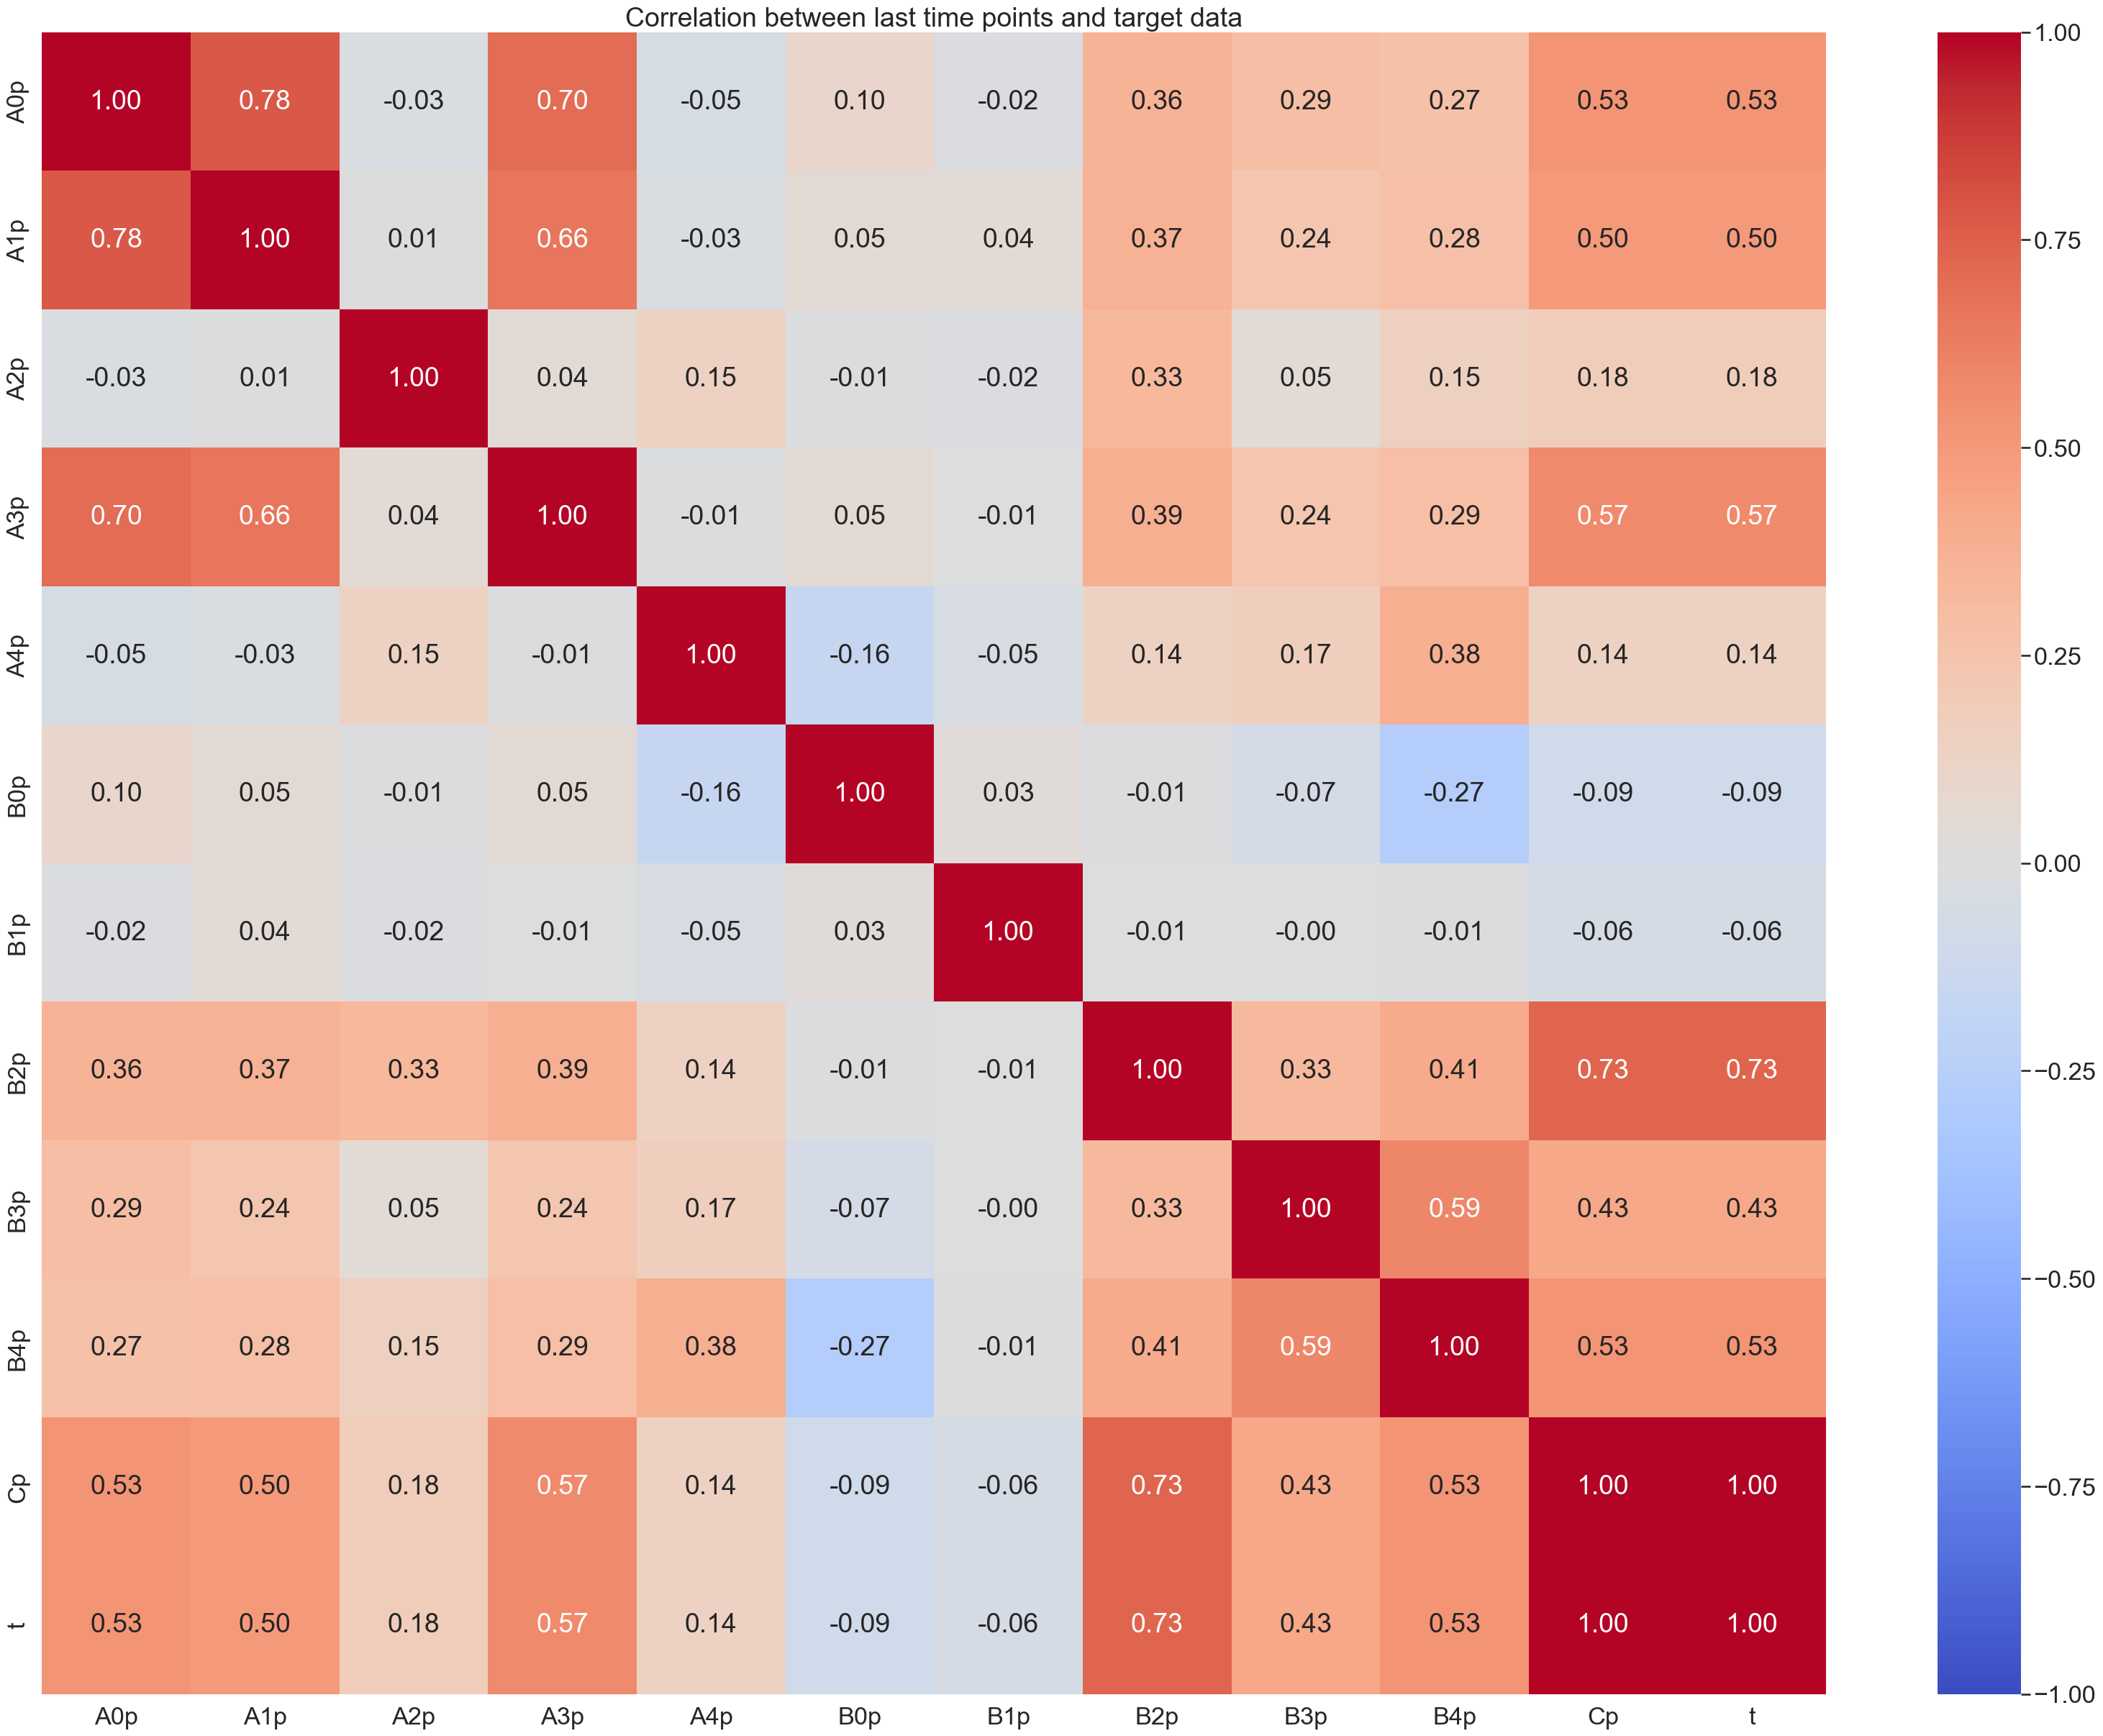

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
# perform correlation analysis between the last time points and the target data
target_last_time_points_S0 = last_time_data.copy()
target_last_time_points_S0['t'] = target_data['Cp']
plt.figure(figsize=(40, 30))
# ensure color map is consistent with the previous heatmap
sns.heatmap(target_last_time_points_S0.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation between last time points and target data')
plt.show()

### Machine Learning Training

In [5]:
def evaluate_model(model, model_name, feature_data, feature_data_name, target_data, test_size=0.2, random_state=4):
    X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # return a dictionary of the model performance
    return {'Model': model_name, 
            'Feature Data': feature_data_name,
            'Mean Squared Error': mean_squared_error(y_test, y_pred),
            'R2 Score': r2_score(y_test, y_pred),
            'Pearson Correlation': pearsonr(y_test, y_pred)[0],
            'Pearson P-Value': pearsonr(y_test, y_pred)[1]
            }
# create a linear regression model
lm = LinearRegression()
# create a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=o_random_seed)
# create a gradient boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=o_random_seed)
# create a support vector machine model
svr = SVR(max_iter=10000)
scaled_svr = Pipeline([('scaler', StandardScaler()), ('svr', svr)])
# create a neural network model (simple)
nn = MLPRegressor(hidden_layer_sizes=(20,), max_iter=10000, random_state=o_random_seed)
scaled_nn = Pipeline([('scaler', StandardScaler()), ('nn', nn)])

all_models = [lm, rf, gb, scaled_svr, scaled_nn]
all_models_desc = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Neural Network']
zipped_model_data = list(zip(all_models, all_models_desc))
all_features = feature_data_list
all_features_desc = feature_data_names
zipped_feature_data = list(zip(all_features, all_features_desc))

# random states are rand ints between 0 and 10000, for n values 
np.random.seed(o_random_seed)
n_random = 10
all_random_states = np.random.randint(0, 10000, n_random)

parallelise = True 
from tqdm import tqdm
# tqdm is a progress bar library, use it to show the progress of the model evaluation
metric_data = []
if not parallelise:          
    for (feature_data, feature_data_name) in tqdm(zipped_feature_data):
        # print('Feature Data:', feature_data_name)
        # print('Feature Data Shape:', feature_data.shape)
        for (model, model_name) in zipped_model_data:
            # print('Model:', model_name)
            for rand in all_random_states:
                metrics = evaluate_model(model, model_name, feature_data, feature_data_name, target_data['Cp'], random_state=rand)
                metric_data.append(metrics)
                
else:        
    # parallelise the model evaluation process using joblib
    from joblib import Parallel, delayed

    metric_data = Parallel(n_jobs=-1)(delayed(evaluate_model)(model, model_name, feature_data, feature_data_name, target_data['Cp'], random_state=rand) 
                                    for (feature_data, feature_data_name) in zipped_feature_data
                                    for (model, model_name) in zipped_model_data
                                    for rand in all_random_states)

# make a dataframe of the metric data
metric_df = pd.DataFrame(metric_data)
metric_df

NameError: name 'feature_data_list' is not defined

In [ ]:
if save_figures: 
    metric_df.to_pickle(experiment_folder+'metric_df.pkl')
    print('Metric data saved to:', experiment_folder+'metric_df.pkl')   


Metric data saved to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp9_new_experiment_5__50/metric_df.pkl


In [6]:
## Load metric data from Metric data saved to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp9_new_experiment_5__50/metric_df.pkl

import pandas as pd
metric_df = pd.read_pickle(experiment_folder+'metric_df.pkl')
print('Metric data loaded from:', experiment_folder+'metric_df.pkl')
import matplotlib.pyplot as plt
import seaborn as sns


Metric data loaded from: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp9_new_experiment_5__50/metric_df.pkl


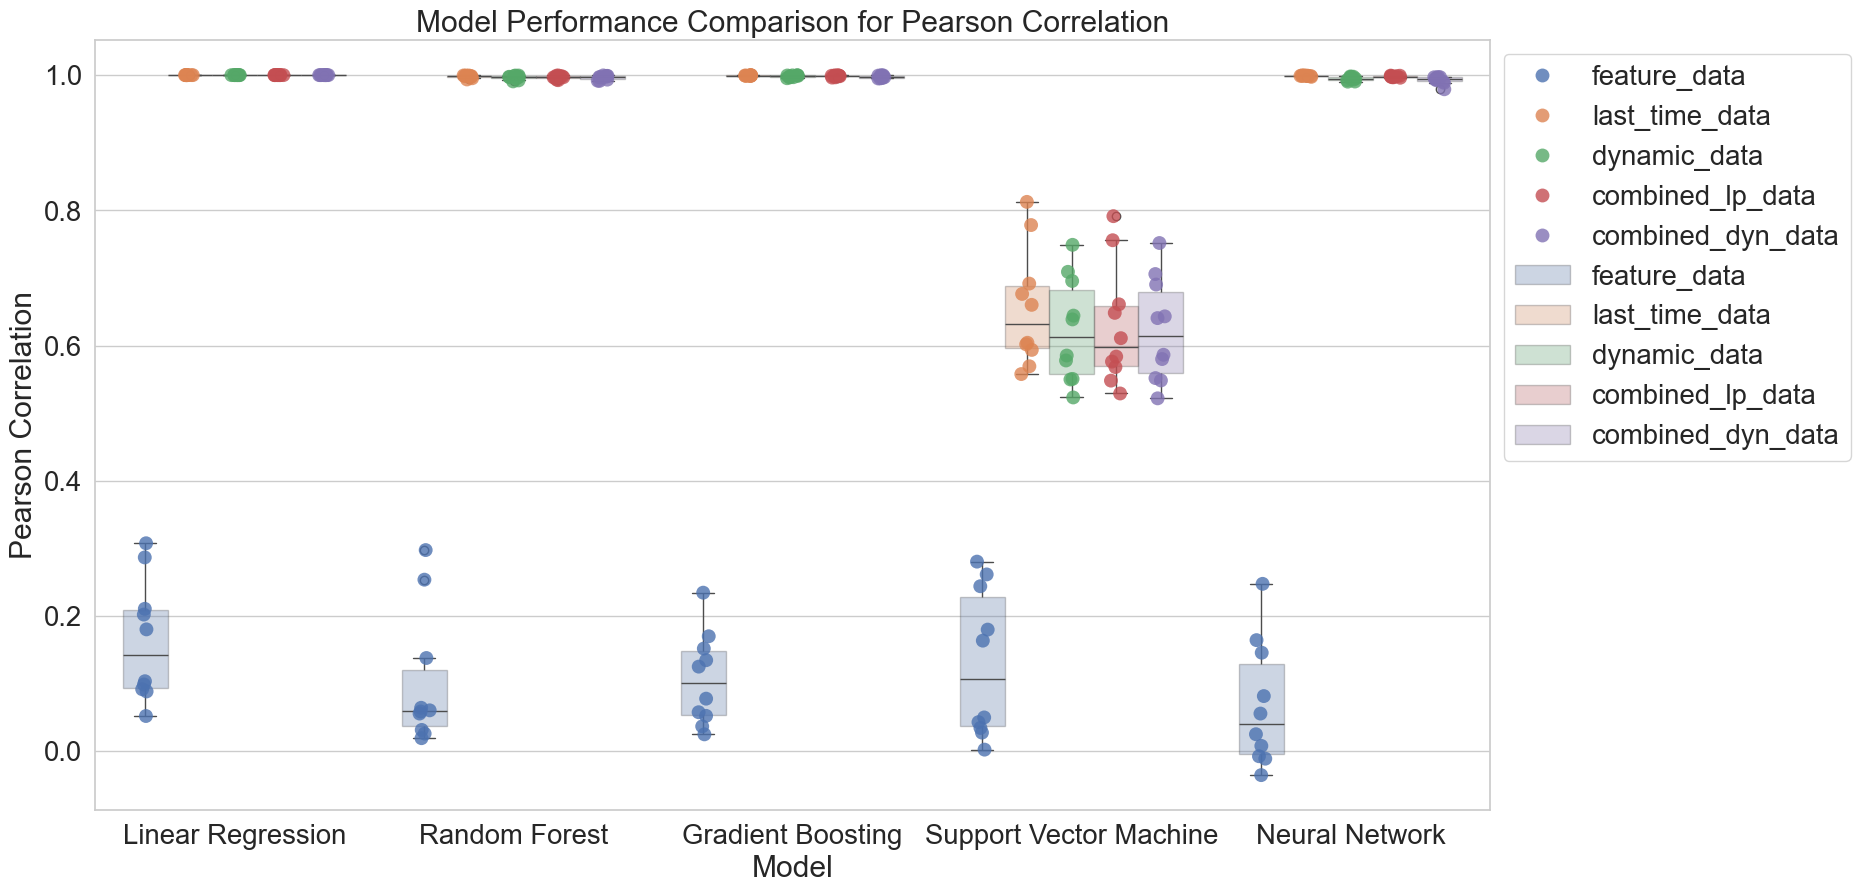

In [7]:
# create box plots for each model type and feature data type, plot for pearson correlation

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# display the mean value for each model and feature data type
mean_vals = metric_df.groupby(['Model', 'Feature Data']).mean().reset_index()
    

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Pearson Correlation')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

if save_figures:
    plt.savefig(experiment_folder + 'Fig_13_model_performance_comparison_pearson.png')
plt.show()

Model performance box plot saved to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp9_new_experiment_5__50/Boxplot_with_model_shapes.png


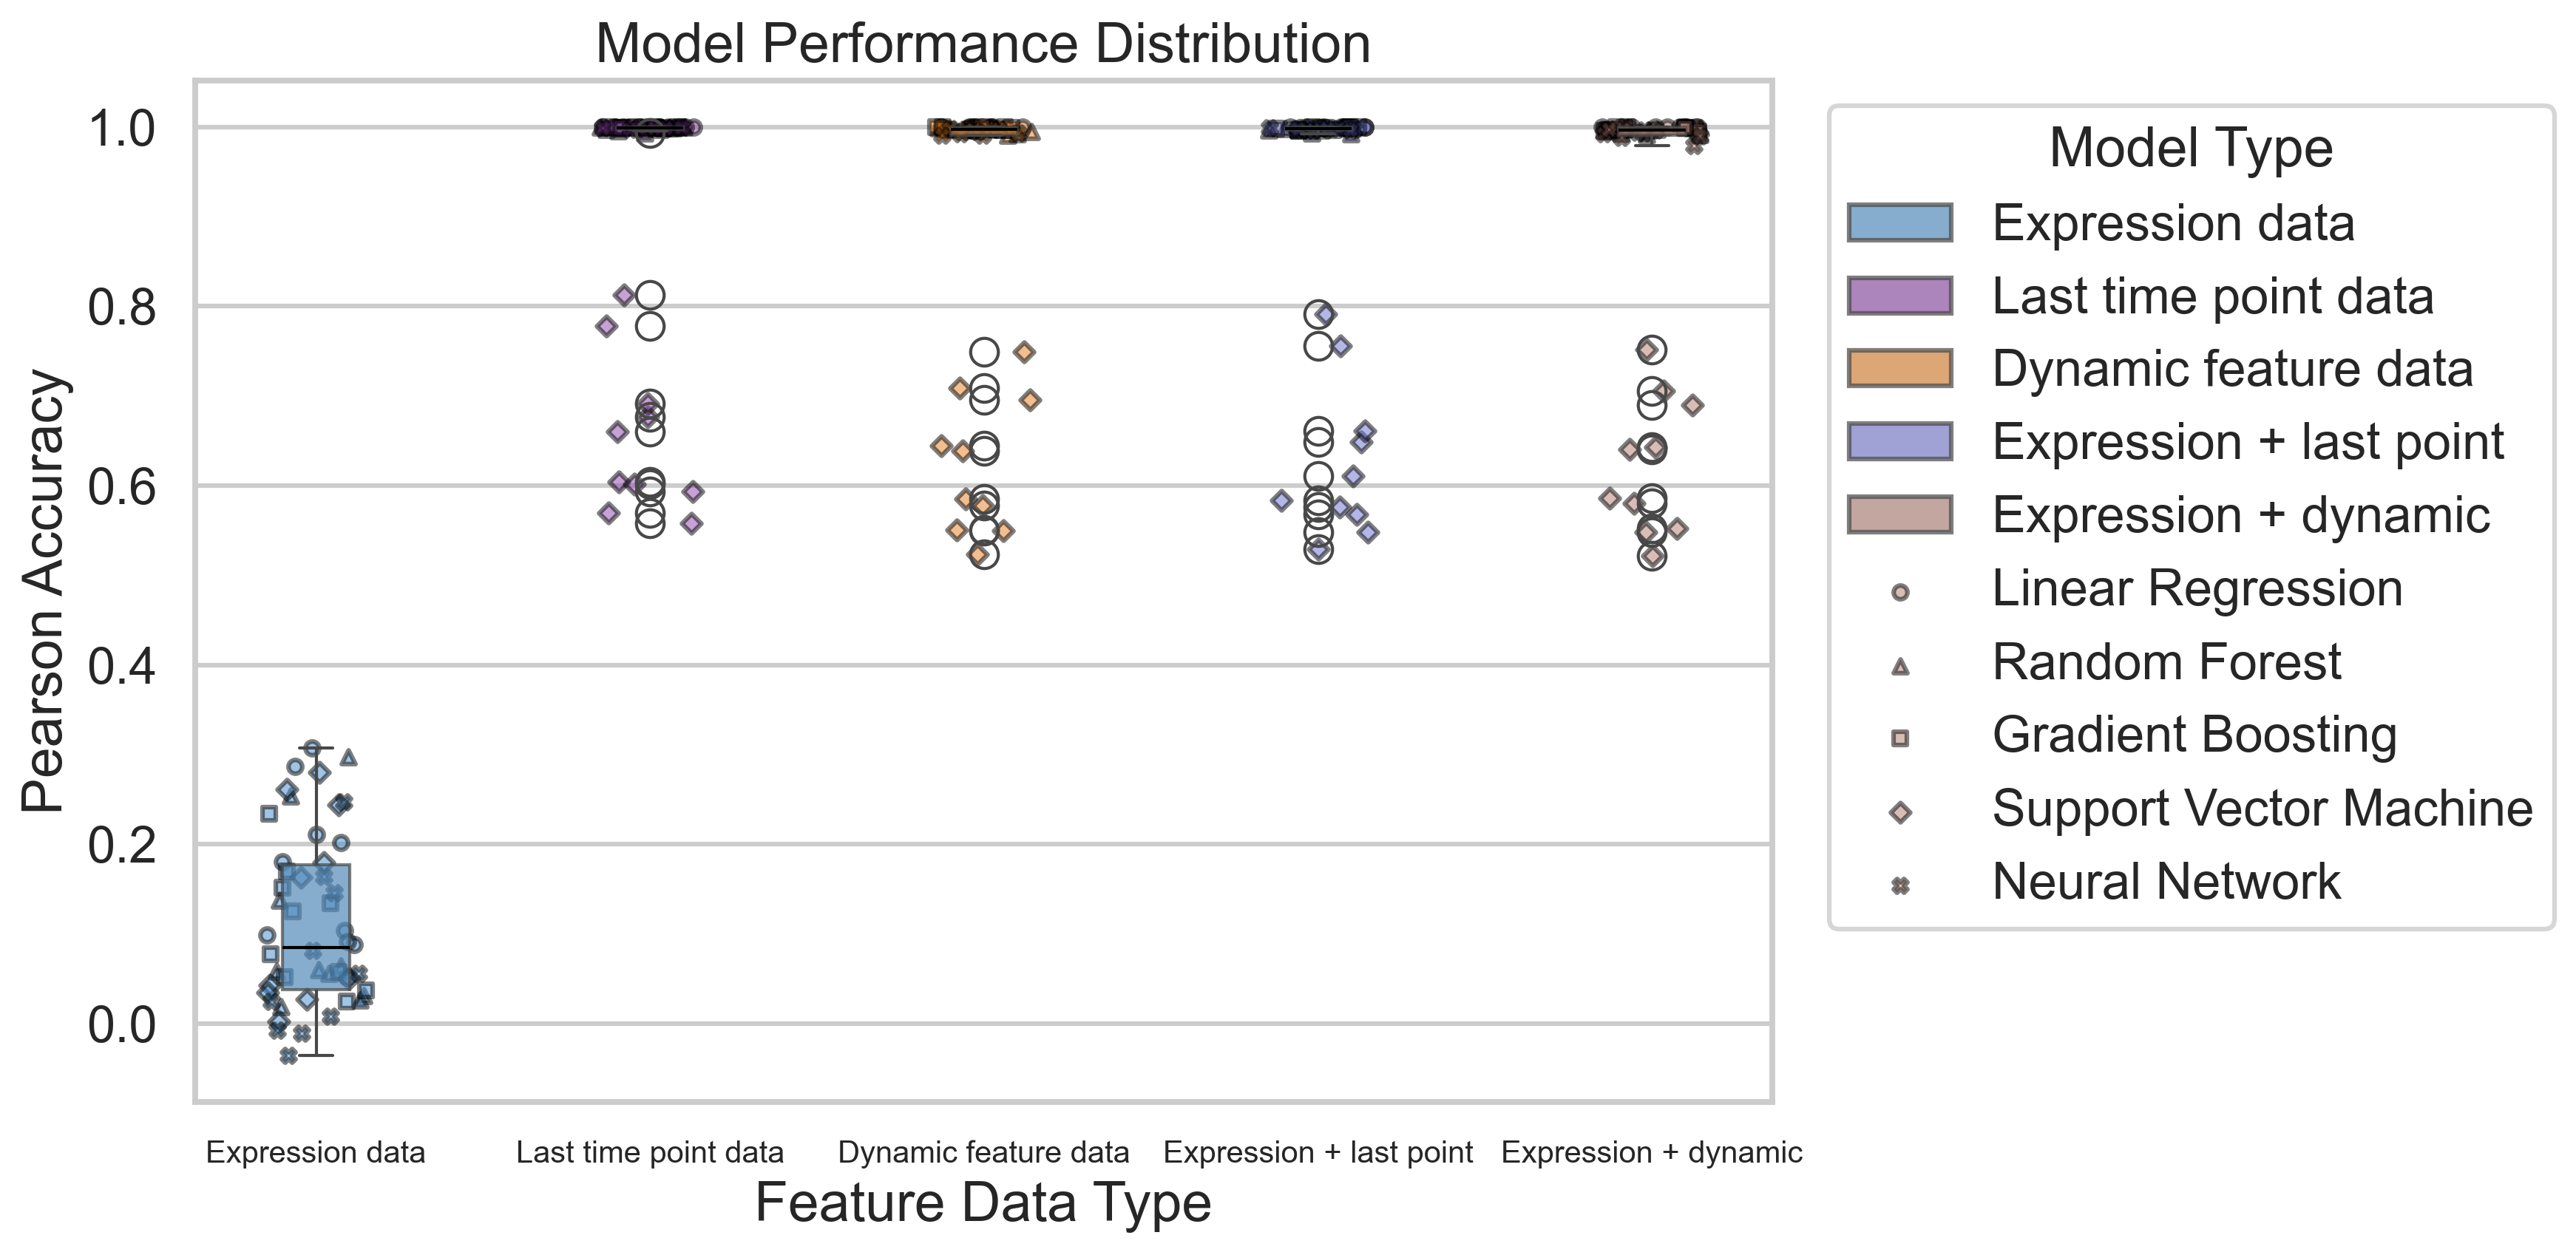

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np

# Define custom markers for each model
model_markers = {
    'Linear Regression': 'o',
    'Random Forest': '^',
    'Gradient Boosting': 's',
    'Support Vector Machine': 'D',
    'Neural Network': 'X'
}

# Color map for feature data types
color_map = {
    'Expression data': '#428bca',
    'Last time point data': '#8e44ad',
    'Dynamic feature data': '#e67e22',
    'Expression + last point': '#6b6fcf',
    'Expression + dynamic': '#b07c6f'
}

# Preprocess data
plot_data = metric_df.copy()
plot_data['Feature Data'] = plot_data['Feature Data'].replace({
    'feature_data': 'Expression data',
    'last_time_data': 'Last time point data',
    'dynamic_data': 'Dynamic feature data',
    'combined_lp_data': 'Expression + last point',
    'combined_dyn_data': 'Expression + dynamic',
    'combined expression + last time point': 'Expression + last point',
    'combined expression + dynamic feature': 'Expression + dynamic'
})


# Get consistent order for feature types
feature_order = list(color_map.keys())

# Plot setup
plt.figure(figsize=(12, 6), dpi=300)
sns.set_context("talk", font_scale=1)
sns.set_style("whitegrid")
matplotlib.rcParams['font.family'] = 'Arial'

# Boxplot
ax = sns.boxplot(
    data=plot_data,
    x='Feature Data',
    y='Pearson Correlation',
    hue='Feature Data',            # Explicitly assign hue
    palette=color_map,
    width=0.2,
    showcaps=True,
    boxprops={'alpha': 0.7},
    medianprops={'color': 'black'},
    legend=True                   # Suppress duplicate legend
)

# Overlay points with custom markers per model
x_positions = {cat: i for i, cat in enumerate(feature_order)}

for model_name, marker in model_markers.items():
    subset = plot_data[plot_data['Model'] == model_name]
    for _, row in subset.iterrows():
        x = x_positions[row['Feature Data']] + np.random.uniform(-0.15, 0.15)
        y = row['Pearson Correlation']
        ax.scatter(x, y,
                   color=color_map[row['Feature Data']],
                   marker=marker,
                   s=20,
                   edgecolor='black',
                   alpha=0.5,
                   label=model_name)

# De-duplicate model legend
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), title="Model Type", bbox_to_anchor=(1.02, 1), loc='upper left')

# Axis styling
plt.title('Model Performance Distribution')
plt.xlabel('Feature Data Type')
plt.ylabel('Pearson Accuracy')
plt.xticks(rotation=0, fontsize=10)
plt.tight_layout()

if save_figures:
    plt.savefig(experiment_folder + 'Boxplot_with_model_shapes.png')
    print('Model performance box plot saved to:', experiment_folder + 'Boxplot_with_model_shapes.png')

plt.show()


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Expression data vs. Dynamic feature data: t-test paired samples, P_val:2.181e-33 t=-3.029e+01
Dynamic feature data vs. Expression + dynamic: t-test paired samples, P_val:4.255e-02 t=2.082e+00
Expression data vs. Expression + dynamic: t-test paired samples, P_val:2.050e-33 t=-3.033e+01
Model performance box plot saved to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp9_new_experiment_5__50/Boxplot_with_dots.png


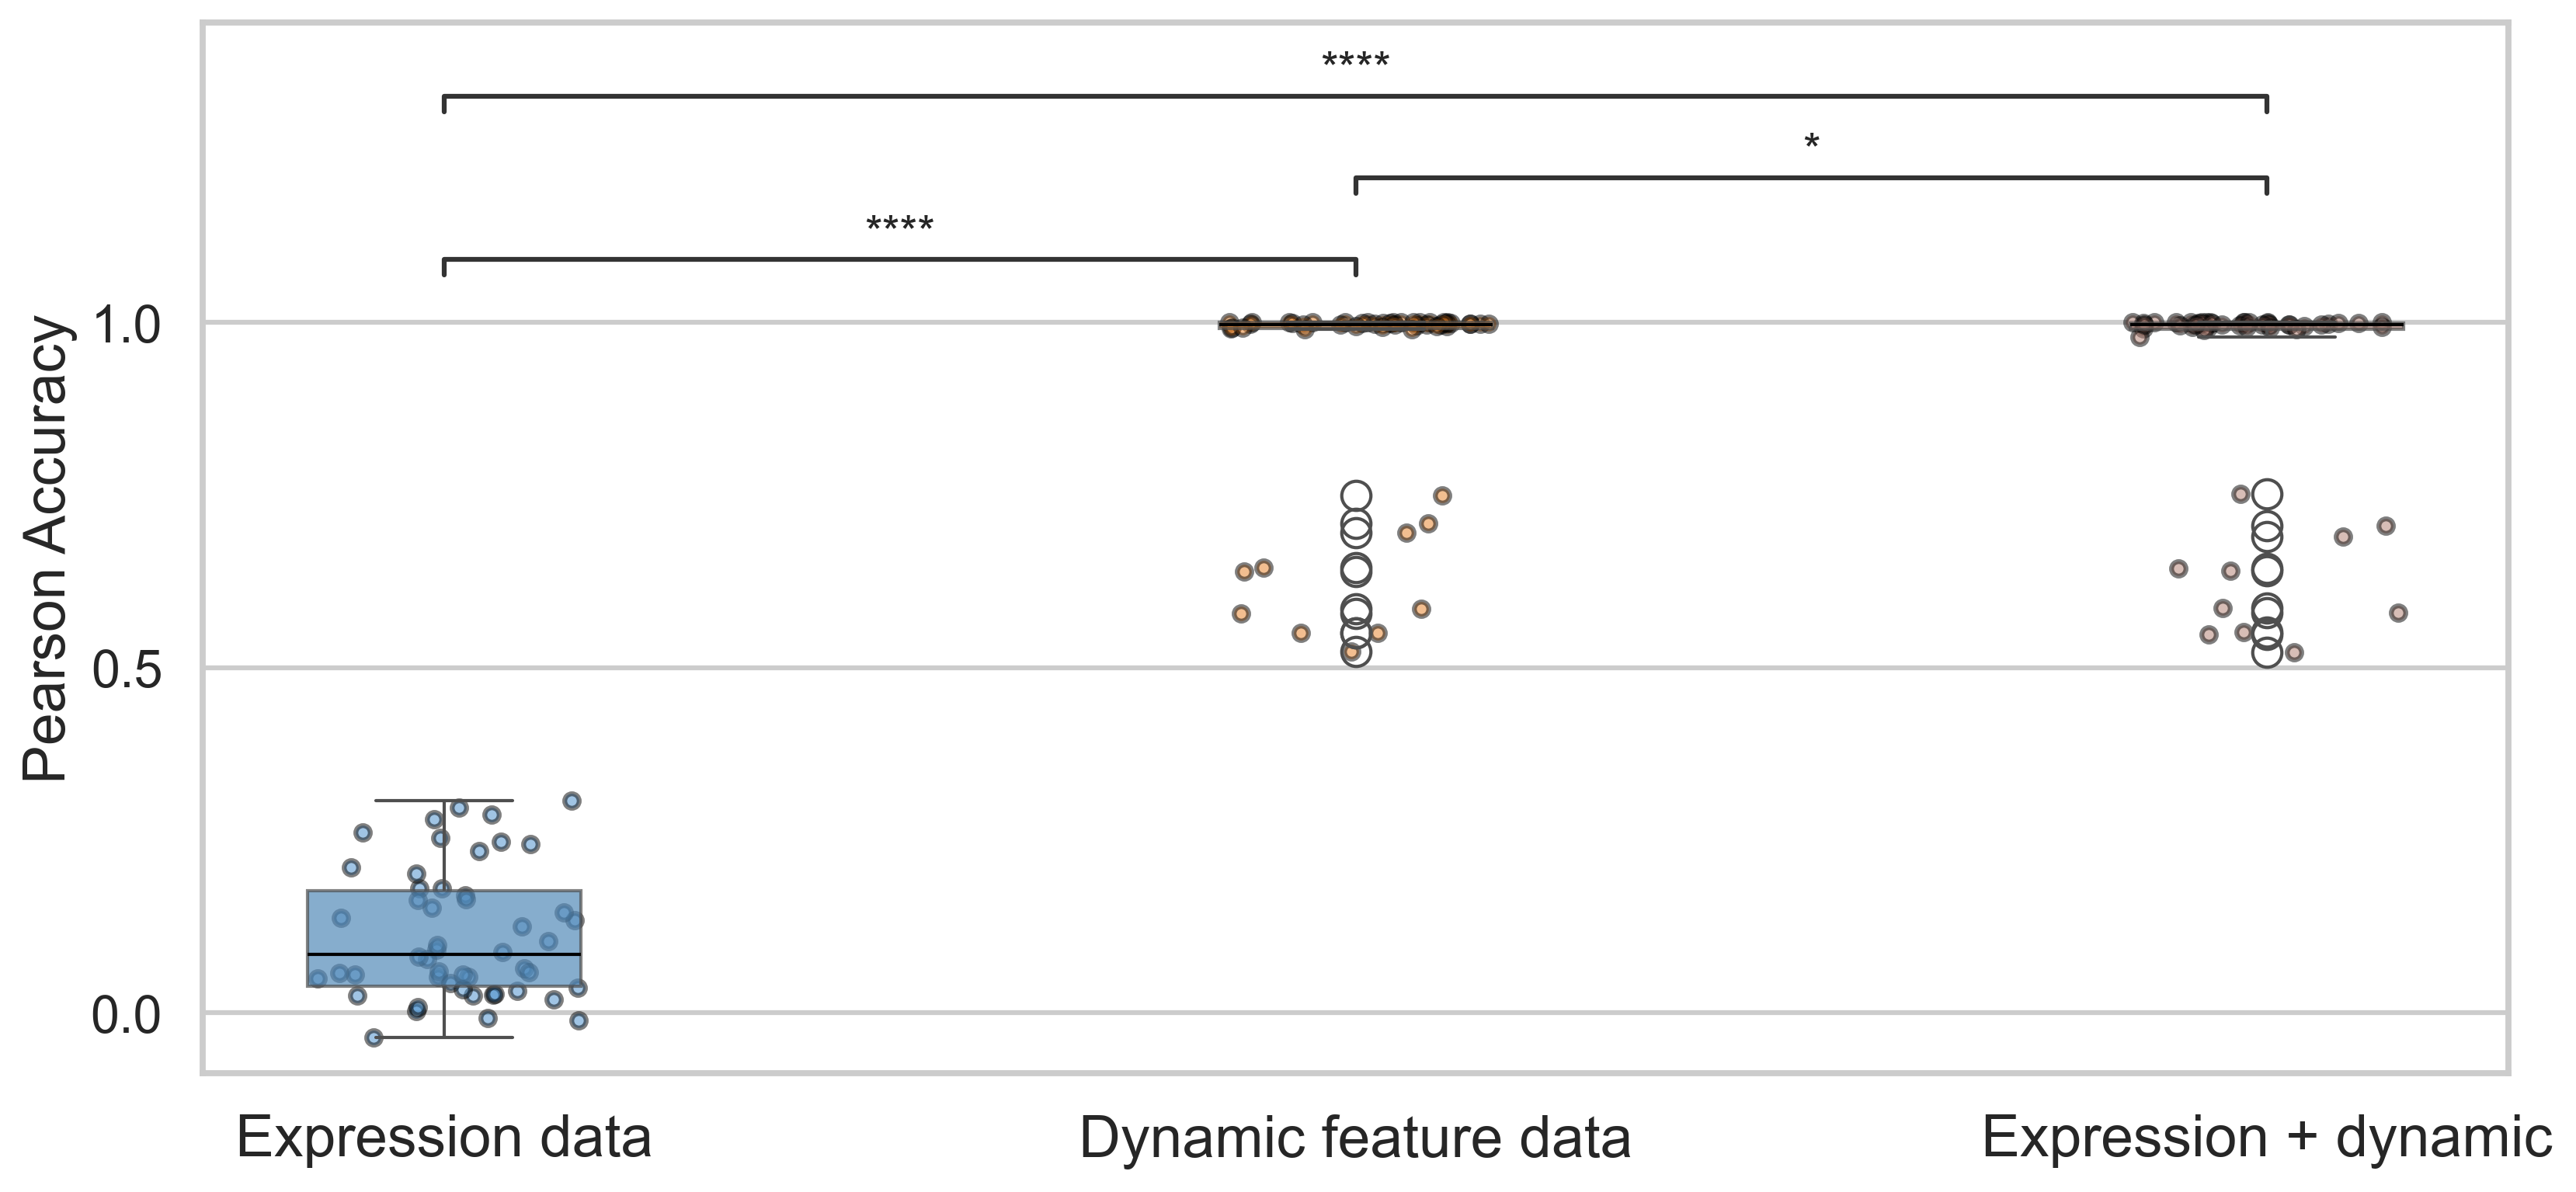

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np
from statannotations.Annotator import Annotator


# Color map (filtered)
color_map = {
    'Expression data': '#428bca',
    'Dynamic feature data': '#e67e22',
    'Expression + dynamic': '#b07c6f'
}

# Define custom markers for each model
model_markers = {
    'Linear Regression': 'o',
    'Random Forest': '^',
    'Gradient Boosting': 's',
    'Support Vector Machine': 'D',
    'Neural Network': 'X'
}

# Preprocess data
plot_data = metric_df.copy()
plot_data['Feature Data'] = plot_data['Feature Data'].replace({
    'feature_data': 'Expression data',
    'last_time_data': 'Last time point data',
    'dynamic_data': 'Dynamic feature data',
    'combined_lp_data': 'Expression + last point',
    'combined_dyn_data': 'Expression + dynamic',
    'combined expression + last time point': 'Expression + last point',
    'combined expression + dynamic feature': 'Expression + dynamic data'
})

# Remove unwanted feature types
plot_data = plot_data[~plot_data['Feature Data'].isin(['Last time point data', 'Expression + last point'])]

# Feature order
feature_order = list(color_map.keys())



# Plot setup
plt.figure(figsize=(12, 6), dpi=300)
sns.set_context("talk", font_scale=2)
sns.set_style("whitegrid")
matplotlib.rcParams['font.family'] = 'Arial'

# Boxplot
ax = sns.boxplot(
    data=plot_data,
    x='Feature Data',
    y='Pearson Correlation',
    hue='Feature Data',
    palette=color_map,
    width=0.3,
    showcaps=True,
    boxprops={'alpha': 0.7},
    medianprops={'color': 'black'}
)

# Define feature comparison pairs and order
pairs = [
    ("Expression data", "Dynamic feature data"),
    ("Expression data", "Expression + dynamic"),
    ("Dynamic feature data", "Expression + dynamic")
]

# Set up annotator
annotator = Annotator(
    ax,
    pairs,
    data=plot_data,
    x='Feature Data',
    y='Pearson Correlation',
    order=feature_order
)

# Configure statistical test and annotation style
annotator.configure(
    test='t-test_paired',     # Use independent t-test
    text_format='star',    # Show stars for significance
    # loc='outside',
    verbose=1,
    fontsize=14,        # smaller font
    line_height=0.02,   # shorter bracket lines
    line_offset=0.01    # closer to the top of the boxes
)

# Apply statistical test and draw annotations
annotator.apply_and_annotate()

# Remove legend if it exists
legend = ax.get_legend()
if legend:
    legend.remove()

# Overlay individual points (same marker for all)
x_positions = {cat: i for i, cat in enumerate(feature_order)}

for _, row in plot_data.iterrows():
    x = x_positions[row['Feature Data']] + np.random.uniform(-0.15, 0.15)
    y = row['Pearson Correlation']
    ax.scatter(
        x, y,
        color=color_map[row['Feature Data']],
        marker='o',
        s=20,
        edgecolor='black',
        alpha=0.5
    )

# Axis styling
plt.title('')
plt.xlabel('', fontsize=14)
plt.ylabel('Pearson Accuracy', fontsize=18)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=16)
plt.tight_layout()



if save_figures:
    plt.savefig(experiment_folder + 'Boxplot_with_dots.png')
    print('Model performance box plot saved to:', experiment_folder + 'Boxplot_with_dots.png')

plt.show()


Group-wise Pearson Correlation (mean ± std):

Expression data          : 0.113 ± 0.094
Dynamic feature data     : 0.922 ± 0.155
Expression + dynamic     : 0.922 ± 0.155
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Expression data vs. Dynamic feature data: t-test paired samples, P_val:2.181e-33 t=-3.029e+01
Dynamic feature data vs. Expression + dynamic: t-test paired samples, P_val:4.255e-02 t=2.082e+00
Expression data vs. Expression + dynamic: t-test paired samples, P_val:2.050e-33 t=-3.033e+01
Plot saved to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp9_new_experiment_5__50/Combined_Boxplot_with_Markers_and_Stats.png


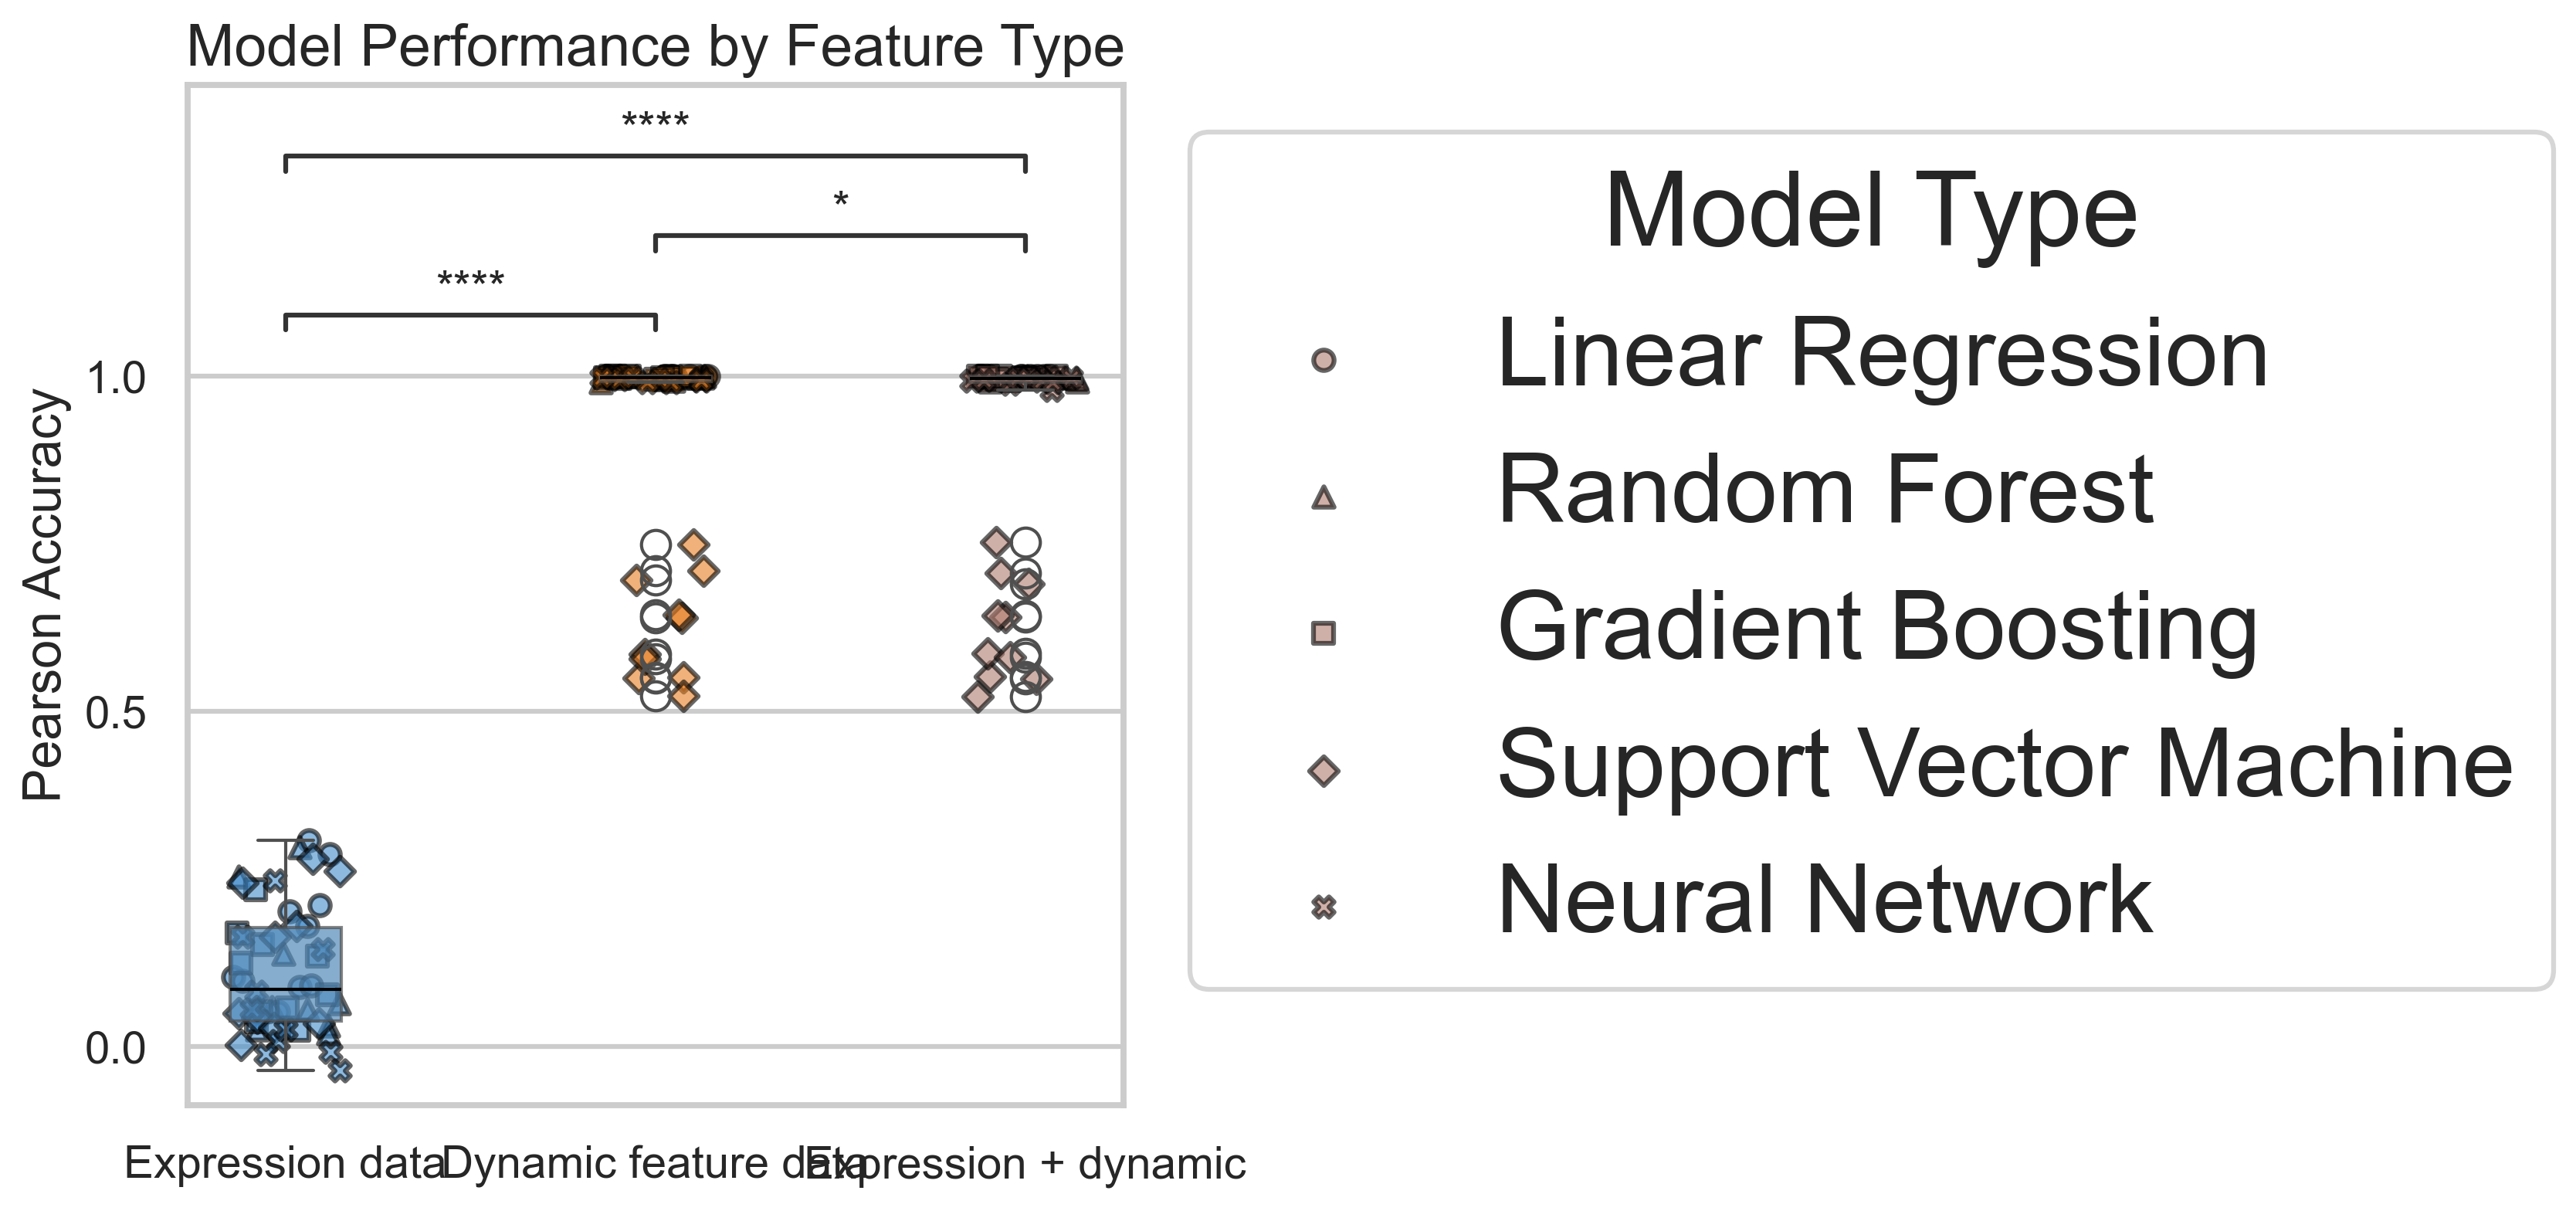

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np
from statannotations.Annotator import Annotator

# Set color and marker styles
color_map = {
    'Expression data': '#428bca',
    'Dynamic feature data': '#e67e22',
    'Expression + dynamic': '#b07c6f'
}

model_markers = {
    'Linear Regression': 'o',
    'Random Forest': '^',
    'Gradient Boosting': 's',
    'Support Vector Machine': 'D',
    'Neural Network': 'X'
}

# Clean and filter the data
plot_data = metric_df.copy()
plot_data['Feature Data'] = plot_data['Feature Data'].replace({
    'feature_data': 'Expression data',
    'last_time_data': 'Last time point data',
    'dynamic_data': 'Dynamic feature data',
    'combined_lp_data': 'Expression + last point',
    'combined_dyn_data': 'Expression + dynamic',
    'combined expression + last time point': 'Expression + last point',
    'combined expression + dynamic feature': 'Expression + dynamic'
})

# Focus only on 3 feature groups
plot_data = plot_data[plot_data['Feature Data'].isin(color_map.keys())]

# Feature order
feature_order = list(color_map.keys())

# Print mean ± std for each box group
print("Group-wise Pearson Correlation (mean ± std):\n")
group_stats = plot_data.groupby('Feature Data')['Pearson Correlation'].agg(['mean', 'std'])
for feature_type in feature_order:
    if feature_type in group_stats.index:
        mean = group_stats.loc[feature_type, 'mean']
        std = group_stats.loc[feature_type, 'std']
        print(f"{feature_type:<25}: {mean:.3f} ± {std:.3f}")

# Create figure
plt.figure(figsize=(12, 6), dpi=300)
sns.set_context("talk", font_scale=1.8)
sns.set_style("whitegrid")
matplotlib.rcParams['font.family'] = 'Arial'

# Boxplot
ax = sns.boxplot(
    data=plot_data,
    x='Feature Data',
    y='Pearson Correlation',
    hue='Feature Data',
    palette=color_map,
    width=0.3,
    showcaps=True,
    boxprops={'alpha': 0.7},
    medianprops={'color': 'black'}
)

# Remove redundant legend
legend = ax.get_legend()
if legend:
    legend.remove()

# Add statannot pairs
pairs = [
    ("Expression data", "Dynamic feature data"),
    ("Expression data", "Expression + dynamic"),
    ("Dynamic feature data", "Expression + dynamic")
]

annotator = Annotator(
    ax,
    pairs,
    data=plot_data,
    x='Feature Data',
    y='Pearson Correlation',
    order=feature_order
)

annotator.configure(
    test='t-test_paired',  # Adjust if data is not paired
    text_format='star',
    verbose=1,
    fontsize=14,
    line_height=0.02,
    line_offset=0.01
)
annotator.apply_and_annotate()

# Add individual model points with custom markers
x_positions = {cat: i for i, cat in enumerate(feature_order)}

for model_name, marker in model_markers.items():
    model_subset = plot_data[plot_data['Model'] == model_name]
    for _, row in model_subset.iterrows():
        x = x_positions[row['Feature Data']] + np.random.uniform(-0.15, 0.15)
        y = row['Pearson Correlation']
        ax.scatter(
            x, y,
            color=color_map[row['Feature Data']],
            marker=marker,
            s=40,
            edgecolor='black',
            alpha=0.6,
            label=model_name
        )

# Deduplicate model marker legend
handles, labels = ax.get_legend_handles_labels()
unique_legend = dict(zip(labels, handles))
ax.legend(unique_legend.values(), unique_legend.keys(), title="Model Type", bbox_to_anchor=(1.02, 1), loc='upper left')

# Label and layout
plt.title('Model Performance by Feature Type', fontsize=18)
plt.xlabel('')
plt.ylabel('Pearson Accuracy', fontsize=16)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Save and show
if save_figures:
    save_path = experiment_folder + 'Combined_Boxplot_with_Markers_and_Stats.png'
    plt.savefig(save_path)
    print('Plot saved to:', save_path)

plt.show()


Group-wise Pearson Correlation (mean ± std):

Expression data          : 0.11300881 ± 0.09381475
Dynamic feature data     : 0.92233775 ± 0.15508671
Expression + dynamic data: 0.92169387 ± 0.15492170
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Expression data vs. Dynamic feature data: t-test paired samples, P_val:2.181e-33 t=-3.029e+01
Dynamic feature data vs. Expression + dynamic data: t-test paired samples, P_val:4.255e-02 t=2.082e+00
Expression data vs. Expression + dynamic data: t-test paired samples, P_val:2.050e-33 t=-3.033e+01
Plot saved to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp9_new_experiment_5__50/Boxplot_with_Separate_Legend.png


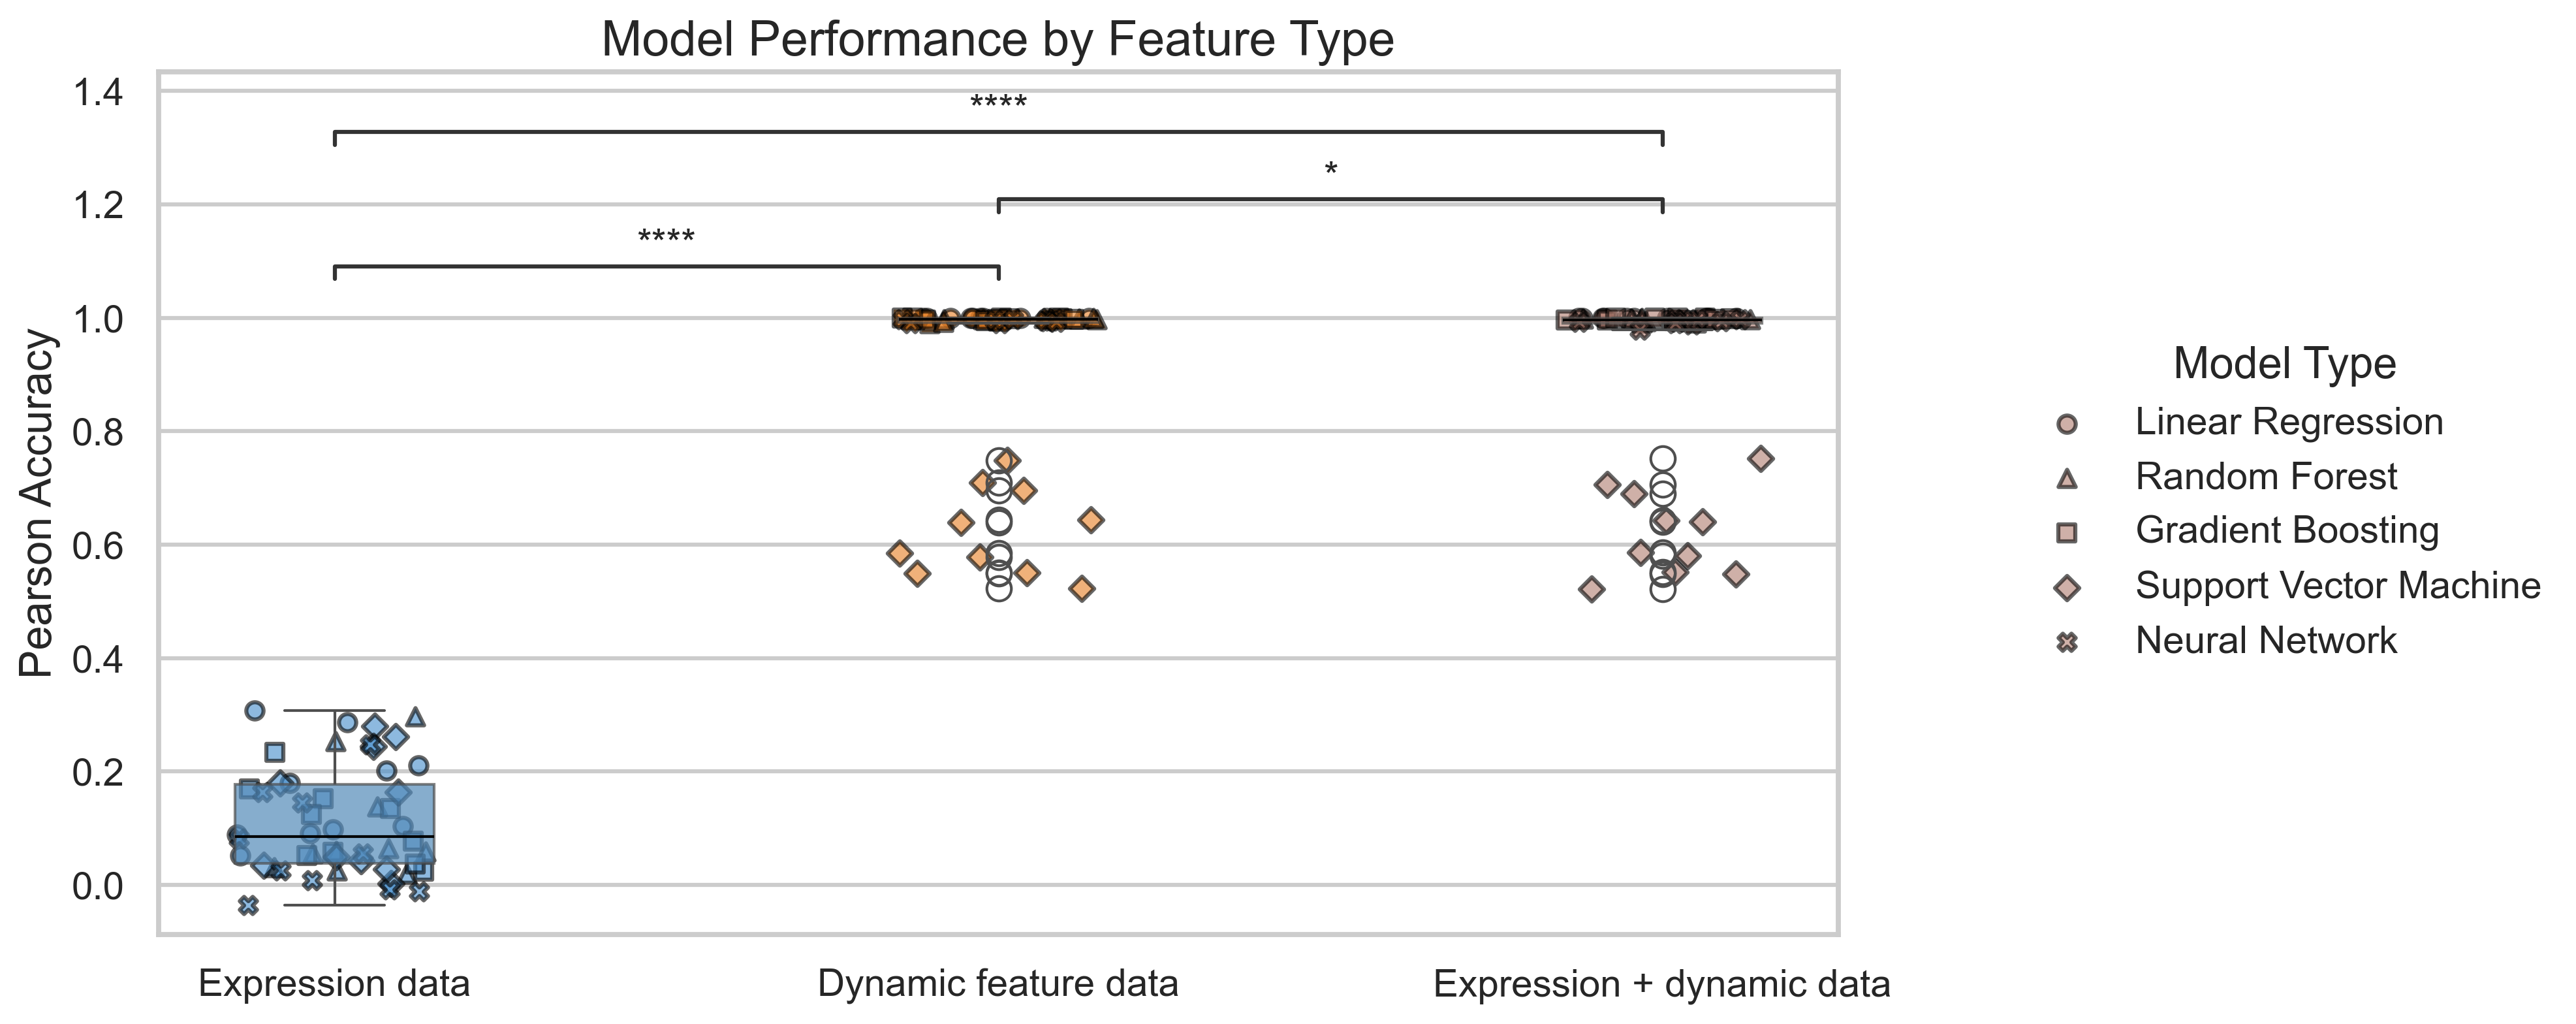

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np
from statannotations.Annotator import Annotator
from matplotlib.gridspec import GridSpec

# Set color and marker styles
color_map = {
    'Expression data': '#428bca',
    'Dynamic feature data': '#e67e22',
    'Expression + dynamic data': '#b07c6f'
}

model_markers = {
    'Linear Regression': 'o',
    'Random Forest': '^',
    'Gradient Boosting': 's',
    'Support Vector Machine': 'D',
    'Neural Network': 'X'
}

# Clean and filter the data
plot_data = metric_df.copy()
plot_data 
plot_data['Feature Data'] = plot_data['Feature Data'].replace({
    'feature_data': 'Expression data',
    'last_time_data': 'Last time point data',
    'dynamic_data': 'Dynamic feature data',
    'combined_lp_data': 'Expression + last point',
    'combined_dyn_data': 'Expression + dynamic data',
})

plot_data = plot_data[plot_data['Feature Data'].isin(color_map.keys())]
feature_order = list(color_map.keys())

# Print group statistics
print("Group-wise Pearson Correlation (mean ± std):\n")
group_stats = plot_data.groupby('Feature Data')['Pearson Correlation'].agg(['mean', 'std'])
for feature_type in feature_order:
    if feature_type in group_stats.index:
        mean = group_stats.loc[feature_type, 'mean']
        std = group_stats.loc[feature_type, 'std']
        print(f"{feature_type:<25}: {mean:.8f} ± {std:.8f}")

# Set plot style
sns.set_context("talk", font_scale=1.8)
sns.set_style("whitegrid")
matplotlib.rcParams['font.family'] = 'Arial'

# Create figure with grid layout
fig = plt.figure(figsize=(14, 6), dpi=300)
gs = GridSpec(1, 2, width_ratios=[5, 1])  # Main plot:legend = 5:1
ax = fig.add_subplot(gs[0])              # Main plot area
legend_ax = fig.add_subplot(gs[1])       # Empty subplot for legend
legend_ax.axis('off')                    # Hide axes

# Boxplot
sns.boxplot(
    data=plot_data,
    x='Feature Data',
    y='Pearson Correlation',
    hue='Feature Data',
    palette=color_map,
    width=0.3,
    showcaps=True,
    boxprops={'alpha': 0.7},
    medianprops={'color': 'black'},
    ax=ax
)

# Remove internal boxplot legend
legend = ax.get_legend()
if legend:
    legend.remove()

# Add statistical annotations
pairs = [
    ("Expression data", "Dynamic feature data"),
    ("Expression data", "Expression + dynamic data"),
    ("Dynamic feature data", "Expression + dynamic data")
]

annotator = Annotator(
    ax,
    pairs,
    data=plot_data,
    x='Feature Data',
    y='Pearson Correlation',
    order=feature_order
)
annotator.configure(
    test='t-test_paired',
    text_format='star',
    verbose=1,
    fontsize=14,
    line_height=0.02,
    line_offset=0.01
)
annotator.apply_and_annotate()

# Overlay model markers
x_positions = {cat: i for i, cat in enumerate(feature_order)}
scatter_handles = []

for model_name, marker in model_markers.items():
    model_subset = plot_data[plot_data['Model'] == model_name]
    handle = None
    for _, row in model_subset.iterrows():
        x = x_positions[row['Feature Data']] + np.random.uniform(-0.15, 0.15)
        y = row['Pearson Correlation']
        sc = ax.scatter(
            x, y,
            color=color_map[row['Feature Data']],
            marker=marker,
            s=40,
            edgecolor='black',
            alpha=0.6
        )
        handle = sc  # Store the last scatter plot (for legend)
    if handle:
        scatter_handles.append((model_name, handle))

# Draw external legend
legend_ax.legend(
    [h for (_, h) in scatter_handles],
    [name for (name, _) in scatter_handles],
    title="Model Type",
    loc='center left',
    frameon=False,
    fontsize=14,
    title_fontsize=16
)

# Axis and title styling
ax.set_title('Model Performance by Feature Type', fontsize=18)
ax.set_xlabel('')
ax.set_ylabel('Pearson Accuracy', fontsize=16)
ax.set_xticks(range(len(feature_order)))
ax.set_xticklabels(feature_order, rotation=0, fontsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.tight_layout()

# Save and show
if save_figures:
    save_path = experiment_folder + 'Boxplot_with_Separate_Legend.png'
    plt.savefig(save_path)
    print('Plot saved to:', save_path)

plt.show()


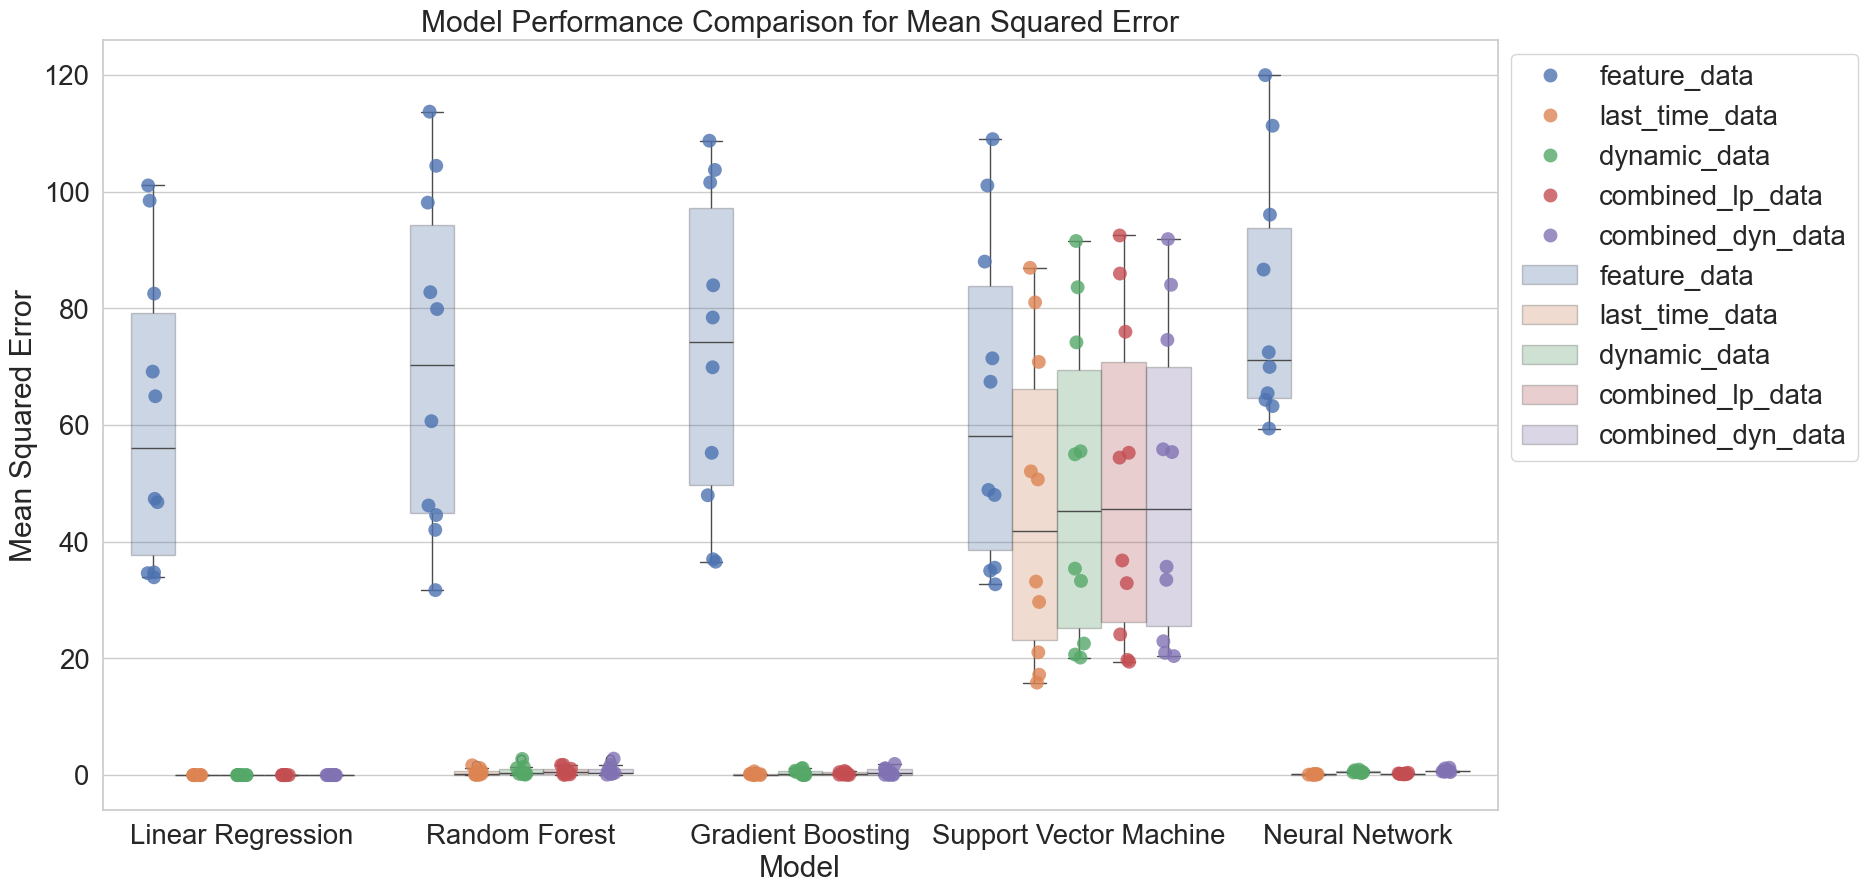

In [ ]:
# create box plots for each model type and feature data type, plot for pearson correlation

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Mean Squared Error', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Mean Squared Error', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Mean Squared Error')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

if save_figures:
    plt.savefig(experiment_folder + 'Fig_14A_all_model_performance_comparison_mse.png')
plt.show()

C:\Users\l8105\AppData\Local\Temp\ipykernel_32756\1609846827.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\l8105\AppData\Local\Temp\ipykernel_32756\1609846827.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\l8105\AppData\Local\Temp\ipykernel_32756\1609846827.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\l8105\AppData\Local\Temp\ipykernel_32756\1609846827.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

Multiplot saved to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp9_new_experiment_5__50/Facet_Model_Performance.png


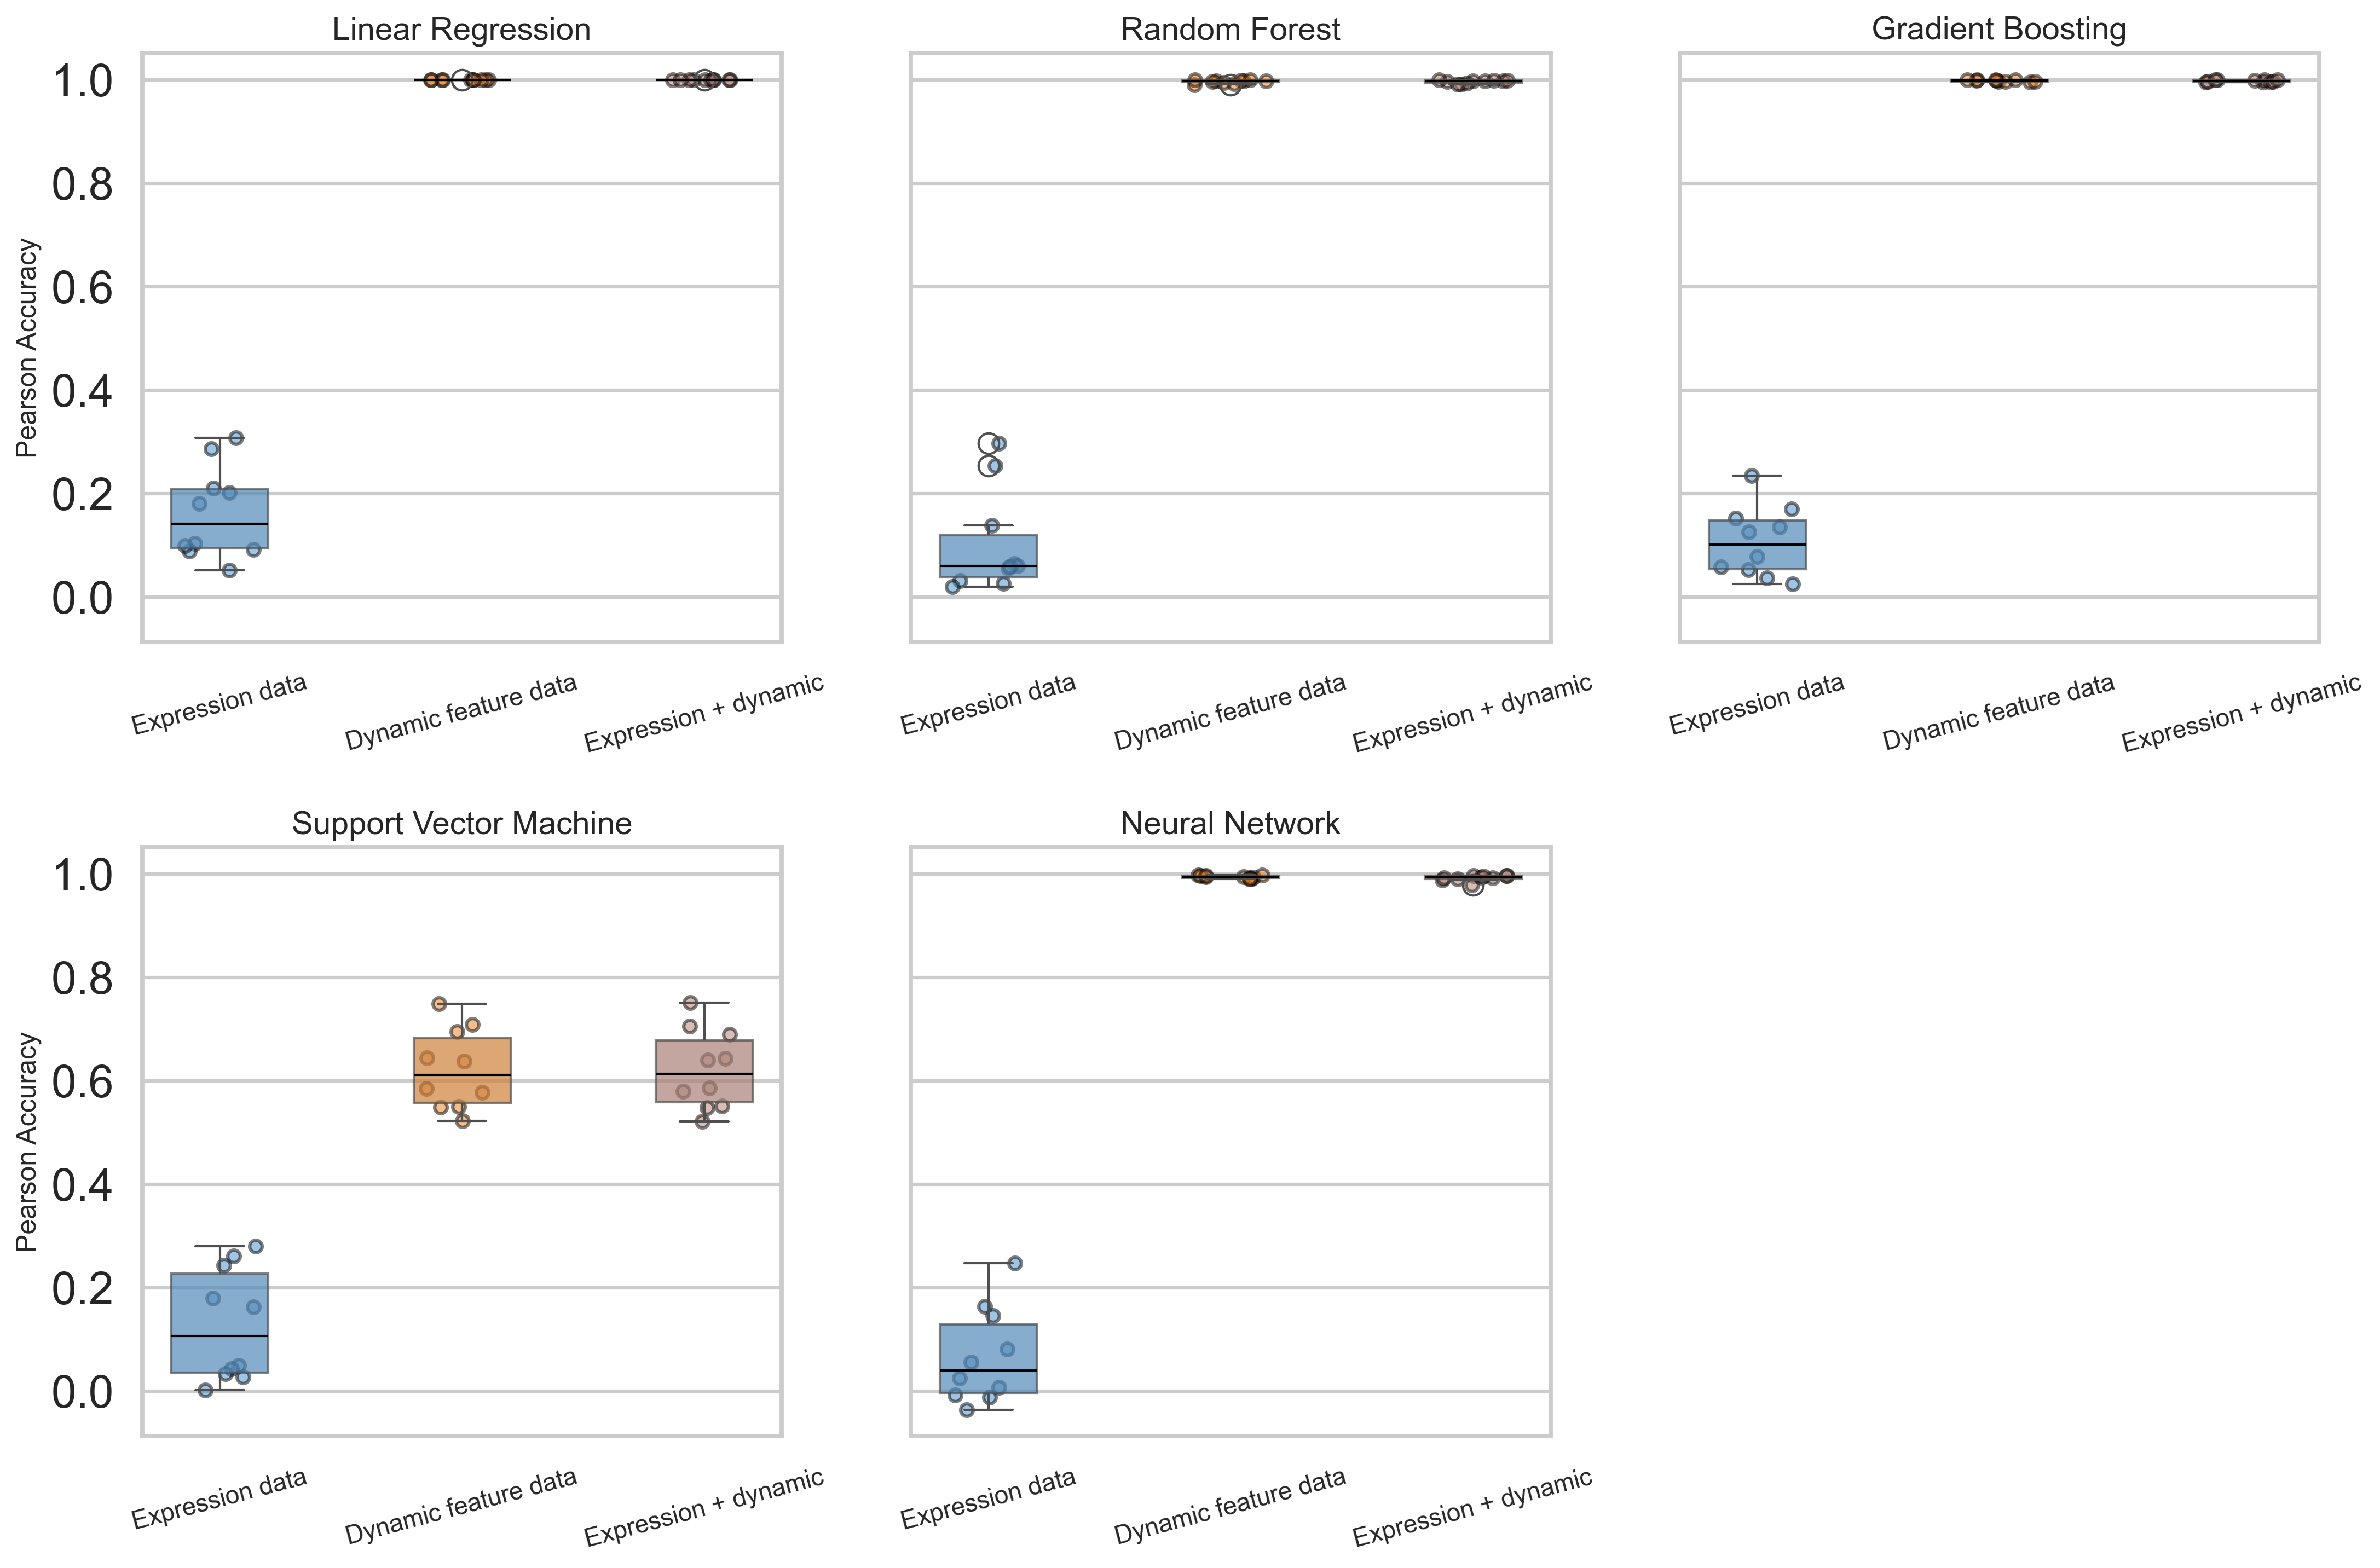

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np

# Plot settings
sns.set_context("talk", font_scale=1.2)
sns.set_style("whitegrid")
matplotlib.rcParams['font.family'] = 'Arial'

# Define color map and feature order
color_map = {
    'Expression data': '#428bca',
    'Dynamic feature data': '#e67e22',
    'Expression + dynamic': '#b07c6f'
}
feature_order = list(color_map.keys())

# Clean data
plot_data = metric_df.copy()
plot_data['Feature Data'] = plot_data['Feature Data'].replace({
    'feature_data': 'Expression data',
    'last_time_data': 'Last time point data',
    'dynamic_data': 'Dynamic feature data',
    'combined_lp_data': 'Expression + last point',
    'combined_dyn_data': 'Expression + dynamic',
    'combined expression + last time point': 'Expression + last point',
    'combined expression + dynamic feature': 'Expression + dynamic'
})
plot_data = plot_data[plot_data['Feature Data'].isin(color_map.keys())]

# Get unique models for faceting
unique_models = plot_data['Model'].unique()
n_models = len(unique_models)

# Set grid size
n_cols = 3
n_rows = int(np.ceil(n_models / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), dpi=300, sharey=True)
axes = axes.flatten()

# Loop through models
for i, model_name in enumerate(unique_models):
    ax = axes[i]
    model_data = plot_data[plot_data['Model'] == model_name]

    # Boxplot per model
    sns.boxplot(
        data=model_data,
        x='Feature Data',
        y='Pearson Correlation',
        order=feature_order,
        palette=color_map,
        ax=ax,
        width=0.4,
        showcaps=True,
        boxprops={'alpha': 0.7},
        medianprops={'color': 'black'}
    )

    # Add individual dots
    x_positions = {cat: j for j, cat in enumerate(feature_order)}
    for _, row in model_data.iterrows():
        x = x_positions[row['Feature Data']] + np.random.uniform(-0.15, 0.15)
        y = row['Pearson Correlation']
        ax.scatter(
            x, y,
            color=color_map[row['Feature Data']],
            marker='o',
            s=30,
            edgecolor='black',
            alpha=0.5
        )

    ax.set_title(model_name, fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('Pearson Accuracy', fontsize=12)
    ax.set_xticks(range(len(feature_order)))
    ax.set_xticklabels(feature_order, rotation=15, fontsize=11)

# Hide unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# Save figure
if save_figures:
    save_path = experiment_folder + 'Facet_Model_Performance.png'
    plt.savefig(save_path)
    print('Multiplot saved to:', save_path)

plt.show()
